Agenda
1. preparation
2. Model

In [1]:
import warnings
warnings.simplefilter('ignore')

import os
import gc
import re
from collections import Counter

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)
from tqdm.auto import tqdm
tqdm.pandas()

from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import confusion_matrix

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1-1. load data

In [3]:
train_logs = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv')
display(train_logs)
train_scores = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv')
display(train_scores)
test_logs = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv')
display(test_logs)

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
...,...,...,...,...,...,...,...,...,...,...,...
8405893,fff05981,3615,2063944,2064440,496,Nonproduction,Leftclick,Leftclick,NoChange,1031,240
8405894,fff05981,3616,2064497,2064497,0,Nonproduction,Shift,Shift,NoChange,1031,240
8405895,fff05981,3617,2064657,2064765,108,Replace,q,q,q => q,1031,240
8405896,fff05981,3618,2069186,2069259,73,Nonproduction,Leftclick,Leftclick,NoChange,1028,240


,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0
...,...,...
2466,ffb8c745,3.5
2467,ffbef7e5,4.0
2468,ffccd6fd,1.5
2469,ffec5b38,5.0


,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,0000aaaa,1,338433,338518,85,Input,Space,Space,,0,0
1,0000aaaa,2,760073,760160,87,Input,Space,Space,,1,0
2,2222bbbb,1,711956,712023,67,Input,q,q,q,0,1
3,2222bbbb,2,290502,290548,46,Input,q,q,q,1,1
4,4444cccc,1,635547,635641,94,Input,Space,Space,,0,0
5,4444cccc,2,184996,185052,56,Input,q,q,q,1,1


In [4]:
result_tmp = pd.DataFrame([dict(Counter(train_logs["activity"]))])

## 1-2. helper functions

### 1-2-1. const definition

In [5]:
# variables category
exp_key_column = "id"
obj_column = "score"

In [6]:
# count_elements
target_activities = ['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste']
target_events = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',', 
          'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete', 'Unidentified']
target_text_changes = ['q', ' ', 'NoChange', '.', ',', '\n', "'", '"', '-', '?', ';', '=', '/', '\\', ':']
target_punctuations = ['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']

In [7]:
def element_counts_in_list(id_colname,id,target_colname,target, target_name):
    #print("============element_counts_in_list================")
    result_tmp = pd.DataFrame([dict(Counter(target))])
    #display(result_tmp)
    result = result_tmp.copy()
    result["tmp"] = 0
    result[id_colname] = id
    final_columns = [id_colname]
    count_element = []
    if target_name == "target_activities":
        count_element = target_activities
    elif target_name == "target_events":
        count_element = target_events
    elif target_name == "target_text_changes":
        count_element = target_text_changes
    #print(count_element)
    for element_col in result_tmp.columns:
        if element_col in count_element:
            result[f"{target_colname}_{element_col}_cnt"] = result_tmp[element_col]
            final_columns.append(f"{target_colname}_{element_col}_cnt")
        else:
            result["tmp"] += result_tmp[element_col]
            result[f"{target_colname}_others_cnt"] = result["tmp"]
            if f"{target_colname}_others_cnt" not in final_columns:
                final_columns.append(f"{target_colname}_others_cnt")
    #display(result[final_columns])
    #final_columns = list(final_columns)
    return result[final_columns]
def element_counts_in_list_vectorize(df, id, target, target_name):
    res = np.vectorize(element_counts_in_list)(id, df[id], target, df[target], target_name)
    return res

In [8]:
def element_counts(df: pd.DataFrame, key_colname: str, count_colname: str, count_elements_name: str, count_elements: list, match: str):
    """
    This function counts each elements
    Parameters
    ----------
    df: DataFrame
    key_colname: aggregator
    count_colname: count columns
    count_elements: count value in this list
    match: exact or partital
        
    Returns
    -------
    d : pd.DataFrame
    """
    print(f"======================element_counts start({count_colname})!!======================")
    tmp_df = df.groupby(key_colname).agg({count_colname: list}).reset_index()
    #display(tmp_df)
    ret = list()
    if match == "exact":
        # def element_counts_in_list(id_colname,id,target_colname,target,count_element):
#         ret = tmp_df.apply(element_counts_in_list,args = (key_colname, tmp_df[key_colname], count_colname, tmp_df[count_colname], count_elements) )
        ret = element_counts_in_list_vectorize(tmp_df, key_colname, count_colname, count_elements_name)
#         for li in tqdm(tmp_df[count_colname].values):
#             items = list(Counter(li).items())
#             di = dict()
#             # make all keys
#             for k in count_elements:
#                 di[k] = 0
#             for item in items:
#                 k,v = item[0], item[1]
#                 if k in di: # this part counts disgnated part
#                     di[k] = v
#             ret.append(di)
        #display(ret)
        ret = pd.DataFrame(ret)
        # display(ret)
        cols = [f"{count_colname}_{i}_count" for i in range(len(ret.columns))]
        ret.columns = cols
        #result = pd.DataFrame()
        #for number in range(len(ret)):
            
    elif match == "partitial":
        for li in tqdm(tmp_df['down_event'].values):
            cnt = 0
            items = list(Counter(li).items())
            for item in items:
                k, v = item[0], item[1]
                if k in count_elements:
                    cnt += v
            ret.append(cnt)
        ret = pd.DataFrame({'punct_cnt': ret})
    return ret
    
def get_input_words(df: pd.DataFrame):
    print("======================get_input_words start!!======================")
    tmp_df = df[(~df["text_change"].str.contains("=>"))&(df["text_change"] != "Nochange")].reset_index(drop= True)
    tmp_df = tmp_df.groupby(exp_key_column).agg({"text_change": list}).reset_index()
    # concat part
    tmp_df["text_change"] = tmp_df["text_change"].apply(lambda x: "".join(x))
    tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: re.findall(r'q+', x))
    
    tmp_df['input_word_count'] = tmp_df['text_change'].apply(len)
    display(tmp_df[["id","text_change"]])
    
    # calc part
    tmp_df['input_word_length_mean'] = tmp_df['text_change'].apply(lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0))
    tmp_df['input_word_length_max'] = tmp_df['text_change'].apply(lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0))
    tmp_df['input_word_length_std'] = tmp_df['text_change'].apply(lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0))
    tmp_df.drop(['text_change'], axis=1, inplace=True)
    return tmp_df

## 1-3. make features

In [9]:
def q1(x):
    return x.quantile(0.1)
def q2(x):
    return x.quantile(0.2)
def q3(x):
    return x.quantile(0.3)
def q4(x):
    return x.quantile(0.4)
def q5(x):
    return x.quantile(0.5)
def q6(x):
    return x.quantile(0.6)
def q7(x):
    return x.quantile(0.7)
def q8(x):
    return x.quantile(0.8)
def q9(x):
    return x.quantile(0.9)

In [10]:
def make_feats(df: pd.DataFrame):
    print("======================make_feats start!!======================")
    feats = pd.DataFrame({exp_key_column: df[exp_key_column].unique().tolist()})
    # time shift
    target_col = "up_time"
    df[f'{target_col}_shift1'] = df.groupby(exp_key_column)[target_col].shift(1) #(going under ↓)
    df['action_time_gap'] = df['down_time'] - df[f'{target_col}_shift1']
    df.drop(f'{target_col}_shift1', axis=1, inplace=True)
    
    # cursor position shift
    target_col = "cursor_position"
    df[f'{target_col}_shift1'] = df.groupby(exp_key_column)[target_col].shift(1)
    df[f'{target_col}_change'] = np.abs(df[target_col] - df[f'{target_col}_shift1'])
    df.drop(f'{target_col}_shift1', axis=1, inplace=True)
    
    # word count shift
    target_col = "word_count"
    df[f'{target_col}_shift1'] = df.groupby(exp_key_column)[target_col].shift(1)
    df[f'{target_col}_change'] = np.abs(df[target_col] - df[f'{target_col}_shift1'])
    df.drop(f'{target_col}_shift1', axis=1, inplace=True)
    
    for item in tqdm([
        ('event_id', ['max']),
        ('up_time', ['max']),
        ('action_time', ['sum', 'max', 'mean', 'std']),
        ('activity', ['nunique']),
        ('down_event', ['nunique']),
        ('up_event', ['nunique']),
        ('text_change', ['nunique']),
        ('cursor_position', ['nunique', 'max', 'mean']),
        ('word_count', ['nunique', 'max', 'mean', "sum", q1, q2, q3, q4, q5, q6, q7, q8, q9]),
        ('action_time_gap', ['max', 'min', 'mean', 'std', 'sum', q1, q2, q3, q4, q5, q6, q7, q8, q9]),
        ('cursor_position_change', ['max', 'mean', 'std', 'sum']),
        ('word_count_change', ['max', 'mean', 'std', 'sum'])
    ]):
        colname, methods = item[0], item[1]
        for method in methods:
            print(f"calc: {method} of {colname}")
            if type(method) == str: 
                tmp_df = df.groupby([exp_key_column]).agg({colname: method}).reset_index().rename(columns = {colname: f"{colname}_{method}"})
                feats = feats.merge(tmp_df, on = exp_key_column, how= "left")
            else:
                tmp_df = df.groupby([exp_key_column]).agg({colname: method}).reset_index().rename(columns = {colname: f"{colname}_{method.__name__}"})
                feats = feats.merge(tmp_df, on = exp_key_column, how= "left")
    
    # counts
#     element_counts(df: pd.DataFrame, key_colname = exp_key_column: str, count_colname: str, count_elements: list, match: str):
    # tmp_df = activity_counts(df)
    tmp_df = pd.DataFrame(element_counts(df, exp_key_column, "activity", "target_activities", target_activities, "exact"))
    #print("==========tmp_df===============")
    elements_counts_df = pd.DataFrame()
    for i in range(len(tmp_df)):
        tmp = pd.DataFrame(tmp_df.iloc[i]).iloc[0,0]
        #display(tmp)
        elements_counts_df = pd.concat([elements_counts_df,tmp.fillna(0)])
        #element_counts_df = pd.concat([elements_counts_df,pd.DataFrame(tmp_df.iloc[i]).iloc[0,0]])
    display(elements_counts_df)
    feats = feats.merge(elements_counts_df,on="id",how="left")
    #display(element_tmp_df)
    #feats = pd.concat([feats, tmp_df], axis=1)
    
    
    tmp_df = element_counts(df, exp_key_column, "down_event", "target_events", target_events, "exact")
    elements_counts_df = pd.DataFrame()
    for i in range(len(tmp_df)):
        tmp = pd.DataFrame(tmp_df.iloc[i]).iloc[0,0]
        #display(tmp)
        elements_counts_df = pd.concat([elements_counts_df,tmp.fillna(0)])
    #display(elements_counts_df)
    feats = feats.merge(elements_counts_df,on="id",how="left")
#     print("==========tmp_df=============")
#     display(tmp_df)
#     feats = pd.concat([feats, tmp_df], axis=1)
    
#     tmp_df = event_counts(df, 'up_event')
    tmp_df = element_counts(df, exp_key_column, "up_event", "target_events", target_events, "exact")
    elements_counts_df = pd.DataFrame()
    for i in range(len(tmp_df)):
        #element_counts_df = pd.concat([elements_counts_df,pd.DataFrame(tmp_df.iloc[i]).iloc[0,0]])
        tmp = pd.DataFrame(tmp_df.iloc[i]).iloc[0,0]
        #display(tmp)
        elements_counts_df = pd.concat([elements_counts_df,tmp.fillna(0)])
    #display(elements_counts_df)
    feats = feats.merge(elements_counts_df,on="id",how="left")
#     print("==========tmp_df=============")
#     display(tmp_df)
#     feats = pd.concat([feats, tmp_df], axis=1)
    
#     tmp_df = text_change_counts(df)
    tmp_df = element_counts(df, exp_key_column, "text_change", "target_text_changes", target_text_changes, "exact")
    elements_counts_df = pd.DataFrame()
    for i in range(len(tmp_df)):
        #element_counts_df = pd.concat([elements_counts_df,pd.DataFrame(tmp_df.iloc[i]).iloc[0,0]])
        tmp = pd.DataFrame(tmp_df.iloc[i]).iloc[0,0]
        #display(tmp)
        #elements_counts_df = pd.concat([elements_counts_df,tmp])
        elements_counts_df = pd.concat([elements_counts_df,tmp.fillna(0)])
    #display(elements_counts_df)
    feats = feats.merge(elements_counts_df,on="id",how="left")
    
    tmp_df = element_counts(df, exp_key_column, "down_event", "target_punctuations", target_punctuations, "partitial")
    feats = pd.concat([feats, tmp_df], axis=1)
    
    
    # input words
    tmp_df = get_input_words(df)
    print("==========tmp_df=============")
    display(tmp_df)
    feats = pd.merge(feats, tmp_df, on='id', how='left')
    
    # compare feats
    feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
    feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
    feats['event_time_ratio'] = feats['event_id_max']  / feats['up_time_max']
    feats['idle_time_ratio'] = feats['action_time_gap_sum'] / feats['up_time_max']
    
    return feats
    

In [11]:
train_feats = make_feats(train_logs)

======================make_feats start!!======================


  0%|          | 0/12 [00:00<?, ?it/s]

calc: max of event_id
calc: max of up_time
calc: sum of action_time
calc: max of action_time
calc: mean of action_time
calc: std of action_time
calc: nunique of activity
calc: nunique of down_event
calc: nunique of up_event
calc: nunique of text_change
calc: nunique of cursor_position
calc: max of cursor_position
calc: mean of cursor_position
calc: nunique of word_count
calc: max of word_count
calc: mean of word_count
calc: sum of word_count
calc: <function q1 at 0x7e5266aa9750> of word_count
calc: <function q2 at 0x7e5266aa9a20> of word_count
calc: <function q3 at 0x7e5266aa9ab0> of word_count
calc: <function q4 at 0x7e5266aa9b40> of word_count
calc: <function q5 at 0x7e5266aa9bd0> of word_count
calc: <function q6 at 0x7e5266aa9c60> of word_count
calc: <function q7 at 0x7e5266aa9cf0> of word_count
calc: <function q8 at 0x7e5266aa9d80> of word_count
calc: <function q9 at 0x7e5266aa9e10> of word_count
calc: max of action_time_gap
calc: min of action_time_gap
calc: mean of action_time_ga

,id,activity_Nonproduction_cnt,activity_Input_cnt,activity_Remove/Cut_cnt,activity_Replace_cnt,activity_others_cnt,activity_Paste_cnt
0,001519c8,120,2010,417.0,7.0,3.0,NaN
0,0022f953,254,1938,260.0,1.0,NaN,1.0
0,0042269b,175,3515,439.0,7.0,NaN,NaN
0,0059420b,99,1304,151.0,1.0,NaN,1.0
0,0075873a,72,1942,517.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
0,ffb8c745,189,3588,960.0,2.0,NaN,NaN
0,ffbef7e5,148,2395,60.0,1.0,NaN,NaN
0,ffccd6fd,126,2849,88.0,NaN,NaN,NaN
0,ffec5b38,71,2895,276.0,NaN,NaN,NaN


======================element_counts start(down_event)!!======================
======================element_counts start(up_event)!!======================
======================element_counts start(text_change)!!======================
======================element_counts start(down_event)!!======================


  0%|          | 0/2471 [00:00<?, ?it/s]

======================get_input_words start!!======================


,id,text_change
0,001519c8,"[qqqqqq, qqq, qqqqqqq, qqqqqq, qq, qqqq, qqqqq..."
1,0022f953,"[qqqq, qq, qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq, ..."
2,0042269b,"[qqqqqqq, qqq, qqqq, qqqq, qqqq, qq, qqqqqqqq,..."
3,0059420b,"[qqqq, qq, qqqqqqq, qqqqqq, q, q, qqq, qqqqqqq..."
4,0075873a,"[qqqqqqqqqqq, qq, q, qq, qqqqq, qq, qqqqqqqqqq..."
...,...,...
2466,ffb8c745,"[qq, qqqqq, q, qqqqqqq, qqq, q, qqqqq, q, qqqq..."
2467,ffbef7e5,"[qqqq, qqqqqq, qqqqq, qq, qqqqq, qqqqq, qq, qq..."
2468,ffccd6fd,"[qqqqqq, qqqq, q, qqqqqqq, qqqqqqqq, q, qq, qq..."
2469,ffec5b38,"[qqqqqqqqqqqq, qqqqqqq, qqqqqq, qqqq, qqqqq, q..."


==========tmp_df=============


,id,input_word_count,input_word_length_mean,input_word_length_max,input_word_length_std
0,001519c8,377,5.169761,20,3.346931
1,0022f953,401,4.234414,33,3.062917
2,0042269b,639,5.344288,25,3.372135
3,0059420b,255,4.537255,15,2.867940
4,0075873a,431,4.556845,14,2.783927
...,...,...,...,...,...
2466,ffb8c745,741,4.869096,20,2.977718
2467,ffbef7e5,473,4.059197,13,2.221528
2468,ffccd6fd,232,4.443966,15,2.693600
2469,ffec5b38,512,5.169922,24,3.419903


In [12]:
test_feats = make_feats(test_logs)

======================make_feats start!!======================


  0%|          | 0/12 [00:00<?, ?it/s]

calc: max of event_id
calc: max of up_time
calc: sum of action_time
calc: max of action_time
calc: mean of action_time
calc: std of action_time
calc: nunique of activity
calc: nunique of down_event
calc: nunique of up_event
calc: nunique of text_change
calc: nunique of cursor_position
calc: max of cursor_position
calc: mean of cursor_position
calc: nunique of word_count
calc: max of word_count
calc: mean of word_count
calc: sum of word_count
calc: <function q1 at 0x7e5266aa9750> of word_count
calc: <function q2 at 0x7e5266aa9a20> of word_count
calc: <function q3 at 0x7e5266aa9ab0> of word_count
calc: <function q4 at 0x7e5266aa9b40> of word_count
calc: <function q5 at 0x7e5266aa9bd0> of word_count
calc: <function q6 at 0x7e5266aa9c60> of word_count
calc: <function q7 at 0x7e5266aa9cf0> of word_count
calc: <function q8 at 0x7e5266aa9d80> of word_count
calc: <function q9 at 0x7e5266aa9e10> of word_count
calc: max of action_time_gap
calc: min of action_time_gap
calc: mean of action_time_ga

,id,activity_Input_cnt
0,0000aaaa,2
0,2222bbbb,2
0,4444cccc,2


======================element_counts start(down_event)!!======================
======================element_counts start(up_event)!!======================
======================element_counts start(text_change)!!======================
======================element_counts start(down_event)!!======================


  0%|          | 0/3 [00:00<?, ?it/s]

======================get_input_words start!!======================


,id,text_change
0,0000aaaa,[]
1,2222bbbb,[qq]
2,4444cccc,[q]


==========tmp_df=============


,id,input_word_count,input_word_length_mean,input_word_length_max,input_word_length_std
0,0000aaaa,0,0.0,0,0.0
1,2222bbbb,1,2.0,2,0.0
2,4444cccc,1,1.0,1,0.0


In [13]:
for col in train_feats.columns:
    if col in test_feats.columns:
        test_feats[col] = test_feats[col]
    else:
        test_feats[col] = 0

In [14]:
test_feats.shape

(3, 114)

In [15]:
train_feats = train_feats.merge(train_scores, on='id', how='left') # join object variance

In [16]:
display(train_feats)
print(train_feats.shape)
for col in train_feats.columns:
    print(col)
display(test_feats)
print(test_feats.shape)
print(test_feats.columns)
for col in test_feats.columns:
    print(col)

,id,event_id_max,up_time_max,action_time_sum,action_time_max,action_time_mean,action_time_std,activity_nunique,down_event_nunique,up_event_nunique,text_change_nunique,cursor_position_nunique,cursor_position_max,cursor_position_mean,word_count_nunique,word_count_max,word_count_mean,word_count_sum,word_count_q1,word_count_q2,word_count_q3,word_count_q4,word_count_q5,word_count_q6,word_count_q7,word_count_q8,word_count_q9,action_time_gap_max,action_time_gap_min,action_time_gap_mean,action_time_gap_std,action_time_gap_sum,action_time_gap_q1,action_time_gap_q2,action_time_gap_q3,action_time_gap_q4,action_time_gap_q5,action_time_gap_q6,action_time_gap_q7,action_time_gap_q8,action_time_gap_q9,cursor_position_change_max,cursor_position_change_mean,cursor_position_change_std,cursor_position_change_sum,word_count_change_max,word_count_change_mean,word_count_change_std,word_count_change_sum,activity_Nonproduction_cnt,activity_Input_cnt,activity_Remove/Cut_cnt,activity_Replace_cnt,activity_others_cnt,activity_Paste_cnt,down_event_Leftclick_cnt,down_event_Shift_cnt,down_event_q_cnt,down_event_Space_cnt,down_event_Backspace_cnt,down_event_._cnt,"down_event_,_cnt",down_event_Enter_cnt,down_event_ArrowLeft_cnt,down_event_'_cnt,down_event_others_cnt,down_event_ArrowRight_cnt,down_event_ArrowUp_cnt,down_event_ArrowDown_cnt,down_event_CapsLock_cnt,down_event_Delete_cnt,down_event_Unidentified_cnt,up_event_Leftclick_cnt,up_event_Shift_cnt,up_event_q_cnt,up_event_Space_cnt,up_event_Backspace_cnt,up_event_._cnt,"up_event_,_cnt",up_event_Enter_cnt,up_event_ArrowLeft_cnt,up_event_'_cnt,up_event_others_cnt,up_event_ArrowRight_cnt,up_event_ArrowUp_cnt,up_event_ArrowDown_cnt,up_event_CapsLock_cnt,up_event_Delete_cnt,up_event_Unidentified_cnt,text_change_NoChange_cnt,text_change_q_cnt,text_change_ _cnt,text_change_._cnt,"text_change_,_cnt",text_change_others_cnt,text_change_\n_cnt,text_change_'_cnt,text_change_;_cnt,text_change_-_cnt,text_change_?_cnt,"text_change_""_cnt",text_change_=_cnt,text_change_/_cnt,text_change_:_cnt,text_change_\_cnt,punct_cnt,input_word_count,input_word_length_mean,input_word_length_max,input_word_length_std,word_time_ratio,word_event_ratio,event_time_ratio,idle_time_ratio,score
0,001519c8,2557,1801969,297243,2259,116.246774,91.797374,7,12,12,17,1469,1539,711.163473,257,256,128.116152,327593,21.0,43.0,71.0,106.0,132.0,160.0,170.0,208.0,237.0,154136.0,-142.0,586.932707,4294.022274,1500200.0,-52.0,-22.0,-3.0,22.0,51.0,70.0,102.0,233.0,707.0,1350.0,4.159624,43.180116,10632.0,2.0,0.172535,0.381013,441.0,120,2010,417.0,7.0,3.0,NaN,92.0,27.0,1619,357,417.0,21.0,12.0,4.0,2.0,3.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,92.0,27.0,1619,357,417.0,21.0,12.0,4.0,2.0,3.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,120,1940,436,28,14.0,9.0,4.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,377,5.169761,20,3.346931,0.000142,0.100117,0.001419,0.832534,3.5
1,0022f953,2454,1788969,275391,1758,112.221271,55.431189,5,17,17,12,1416,1676,776.205786,324,323,182.714751,448382,34.3,81.0,124.0,162.0,186.0,221.0,252.0,284.0,315.0,145899.0,-166.0,604.547493,4897.303641,1482955.0,-34.8,-13.0,21.0,32.0,52.0,74.0,103.0,185.0,547.8,1581.0,9.819405,84.785626,24087.0,1.0,0.170404,0.376064,418.0,254,1938,260.0,1.0,NaN,1.0,56.0,97.0,1490,391,260.0,15.0,21.0,6.0,49.0,3.0,15.0,46.0,2.0,3.0,NaN,NaN,NaN,56.0,97.0,1490,391,260.0,15.0,21.0,6.0,49.0,3.0,15.0,46.0,2.0,3.0,NaN,NaN,NaN,254,1698,432,18,24.0,2.0,7.0,4.0,NaN,6.0,3.0,6.0,NaN,NaN,NaN,NaN,53,401,4.234414,33,3.062917,0.000181,0.131622,0.001372,0.828944,3.5
2,0042269b,4136,1771669,421201,3005,101.837766,82.383766,4,13,18,19,1649,2291,731.611702,405,404,194.772727,805580,34.5,89.0,133.0,176.0,193.0,214.0,262.0,295.0,350.0,153886.0,-250.0,325.520435,3937.359025,1346027.0,-57.0,-40.0,-25.0,-7.0,0.0,13.0,39.0,86.0,196.0,1862.0,6.531318,71.786451,27007.0,28.0,0.167836,0.644564,694.0,175,3515,439.0,7.0,NaN,NaN,129.0,39.0,2904,552,439.0,21.0,23.0,17.0,NaN,NaN,6.0,6.0,NaN,NaN,NaN,NaN,NaN,129.0,39.0,2899,552,439.0,21.0,23.0,17.0,NaN,NaN,11.0,6.0,NaN,NaN,NaN,N

(2471, 115)
id
event_id_max
up_time_max
action_time_sum
action_time_max
action_time_mean
action_time_std
activity_nunique
down_event_nunique
up_event_nunique
text_change_nunique
cursor_position_nunique
cursor_position_max
cursor_position_mean
word_count_nunique
word_count_max
word_count_mean
word_count_sum
word_count_q1
word_count_q2
word_count_q3
word_count_q4
word_count_q5
word_count_q6
word_count_q7
word_count_q8
word_count_q9
action_time_gap_max
action_time_gap_min
action_time_gap_mean
action_time_gap_std
action_time_gap_sum
action_time_gap_q1
action_time_gap_q2
action_time_gap_q3
action_time_gap_q4
action_time_gap_q5
action_time_gap_q6
action_time_gap_q7
action_time_gap_q8
action_time_gap_q9
cursor_position_change_max
cursor_position_change_mean
cursor_position_change_std
cursor_position_change_sum
word_count_change_max
word_count_change_mean
word_count_change_std
word_count_change_sum
activity_Nonproduction_cnt
activity_Input_cnt
activity_Remove/Cut_cnt
activity_Replace_cnt
activ

,id,event_id_max,up_time_max,action_time_sum,action_time_max,action_time_mean,action_time_std,activity_nunique,down_event_nunique,up_event_nunique,text_change_nunique,cursor_position_nunique,cursor_position_max,cursor_position_mean,word_count_nunique,word_count_max,word_count_mean,word_count_sum,word_count_q1,word_count_q2,word_count_q3,word_count_q4,word_count_q5,word_count_q6,word_count_q7,word_count_q8,word_count_q9,action_time_gap_max,action_time_gap_min,action_time_gap_mean,action_time_gap_std,action_time_gap_sum,action_time_gap_q1,action_time_gap_q2,action_time_gap_q3,action_time_gap_q4,action_time_gap_q5,action_time_gap_q6,action_time_gap_q7,action_time_gap_q8,action_time_gap_q9,cursor_position_change_max,cursor_position_change_mean,cursor_position_change_std,cursor_position_change_sum,word_count_change_max,word_count_change_mean,word_count_change_std,word_count_change_sum,activity_Input_cnt,down_event_Space_cnt,down_event_q_cnt,up_event_Space_cnt,up_event_q_cnt,text_change_ _cnt,text_change_q_cnt,punct_cnt,input_word_count,input_word_length_mean,input_word_length_max,input_word_length_std,word_time_ratio,word_event_ratio,event_time_ratio,idle_time_ratio,activity_Nonproduction_cnt,activity_Remove/Cut_cnt,activity_Replace_cnt,activity_others_cnt,activity_Paste_cnt,down_event_Leftclick_cnt,down_event_Shift_cnt,down_event_Backspace_cnt,down_event_._cnt,"down_event_,_cnt",down_event_Enter_cnt,down_event_ArrowLeft_cnt,down_event_'_cnt,down_event_others_cnt,down_event_ArrowRight_cnt,down_event_ArrowUp_cnt,down_event_ArrowDown_cnt,down_event_CapsLock_cnt,down_event_Delete_cnt,down_event_Unidentified_cnt,up_event_Leftclick_cnt,up_event_Shift_cnt,up_event_Backspace_cnt,up_event_._cnt,"up_event_,_cnt",up_event_Enter_cnt,up_event_ArrowLeft_cnt,up_event_'_cnt,up_event_others_cnt,up_event_ArrowRight_cnt,up_event_ArrowUp_cnt,up_event_ArrowDown_cnt,up_event_CapsLock_cnt,up_event_Delete_cnt,up_event_Unidentified_cnt,text_change_NoChange_cnt,text_change_._cnt,"text_change_,_cnt",text_change_others_cnt,text_change_\n_cnt,text_change_'_cnt,text_change_;_cnt,text_change_-_cnt,text_change_?_cnt,"text_change_""_cnt",text_change_=_cnt,text_change_/_cnt,text_change_:_cnt,text_change_\_cnt
0,0000aaaa,2,760160,172,87,86.0,1.414214,1,1,1,1,2,1,0.5,1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,421555.0,421555.0,421555.0,NaN,421555.0,421555.0,421555.0,421555.0,421555.0,421555.0,421555.0,421555.0,421555.0,421555.0,1.0,1.0,NaN,1.0,0.0,0.0,NaN,0.0,2,2.0,NaN,2.0,NaN,2.0,NaN,0,0,0.0,0,0.0,0.000000,0.0,0.000003,0.554561,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2222bbbb,2,712023,113,67,56.5,14.849242,1,1,1,1,2,1,0.5,1,1,1.0,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-421521.0,-421521.0,-421521.0,NaN,-421521.0,-421521.0,-421521.0,-421521.0,-421521.0,-421521.0,-421521.0,-421521.0,-421521.0,-421521.0,1.0,1.0,NaN,1.0,0.0,0.0,NaN,0.0,2,NaN,2.0,NaN,2.0,NaN,2.0,0,1,2.0,2,0.0,0.000001,0.5,0.000003,-0.592005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4444cccc,2,635641,150,94,75.0,26.870058,1,2,2,2,2,1,0.5,2,1,0.5,1,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,-450645.0,-450645.0,-450645.0,NaN,-450645.0,-450645.0,-450645.0,-450645.0,-450645.0,-450645.0,-450645.0,-450645.0,-450645.0,-450645.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,2,1.0,1.0,1.0,1.0,1.0,1.0,0,1,1.0,1,0.0,0.000002,0.5,0.000003,-0.708962,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


(3, 114)
Index(['id', 'event_id_max', 'up_time_max', 'action_time_sum',
       'action_time_max', 'action_time_mean', 'action_time_std',
       'activity_nunique', 'down_event_nunique', 'up_event_nunique',
       ...
       'text_change_\n_cnt', 'text_change_'_cnt', 'text_change_;_cnt',
       'text_change_-_cnt', 'text_change_?_cnt', 'text_change_"_cnt',
       'text_change_=_cnt', 'text_change_/_cnt', 'text_change_:_cnt',
       'text_change_\_cnt'],
      dtype='object', length=114)
id
event_id_max
up_time_max
action_time_sum
action_time_max
action_time_mean
action_time_std
activity_nunique
down_event_nunique
up_event_nunique
text_change_nunique
cursor_position_nunique
cursor_position_max
cursor_position_mean
word_count_nunique
word_count_max
word_count_mean
word_count_sum
word_count_q1
word_count_q2
word_count_q3
word_count_q4
word_count_q5
word_count_q6
word_count_q7
word_count_q8
word_count_q9
action_time_gap_max
action_time_gap_min
action_time_gap_mean
action_time_gap_std
action

In [17]:
# in order to use data in model , change colname
col_map_org_to_new = {}
col_map_new_to_org = {}
for i,col in enumerate(train_feats.columns):
    if col not in [exp_key_column , obj_column]:
        col_map_org_to_new[col] = f"col_{i}"
        col_map_new_to_org[f"col_{i}"] = col

In [18]:
train_feats = train_feats.rename(columns= col_map_org_to_new)
test_feats = test_feats.rename(columns= col_map_org_to_new)

In [19]:
train_feats

,id,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51,col_52,col_53,col_54,col_55,col_56,col_57,col_58,col_59,col_60,col_61,col_62,col_63,col_64,col_65,col_66,col_67,col_68,col_69,col_70,col_71,col_72,col_73,col_74,col_75,col_76,col_77,col_78,col_79,col_80,col_81,col_82,col_83,col_84,col_85,col_86,col_87,col_88,col_89,col_90,col_91,col_92,col_93,col_94,col_95,col_96,col_97,col_98,col_99,col_100,col_101,col_102,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,col_112,col_113,score
0,001519c8,2557,1801969,297243,2259,116.246774,91.797374,7,12,12,17,1469,1539,711.163473,257,256,128.116152,327593,21.0,43.0,71.0,106.0,132.0,160.0,170.0,208.0,237.0,154136.0,-142.0,586.932707,4294.022274,1500200.0,-52.0,-22.0,-3.0,22.0,51.0,70.0,102.0,233.0,707.0,1350.0,4.159624,43.180116,10632.0,2.0,0.172535,0.381013,441.0,120,2010,417.0,7.0,3.0,NaN,92.0,27.0,1619,357,417.0,21.0,12.0,4.0,2.0,3.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,92.0,27.0,1619,357,417.0,21.0,12.0,4.0,2.0,3.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,120,1940,436,28,14.0,9.0,4.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,377,5.169761,20,3.346931,0.000142,0.100117,0.001419,0.832534,3.5
1,0022f953,2454,1788969,275391,1758,112.221271,55.431189,5,17,17,12,1416,1676,776.205786,324,323,182.714751,448382,34.3,81.0,124.0,162.0,186.0,221.0,252.0,284.0,315.0,145899.0,-166.0,604.547493,4897.303641,1482955.0,-34.8,-13.0,21.0,32.0,52.0,74.0,103.0,185.0,547.8,1581.0,9.819405,84.785626,24087.0,1.0,0.170404,0.376064,418.0,254,1938,260.0,1.0,NaN,1.0,56.0,97.0,1490,391,260.0,15.0,21.0,6.0,49.0,3.0,15.0,46.0,2.0,3.0,NaN,NaN,NaN,56.0,97.0,1490,391,260.0,15.0,21.0,6.0,49.0,3.0,15.0,46.0,2.0,3.0,NaN,NaN,NaN,254,1698,432,18,24.0,2.0,7.0,4.0,NaN,6.0,3.0,6.0,NaN,NaN,NaN,NaN,53,401,4.234414,33,3.062917,0.000181,0.131622,0.001372,0.828944,3.5
2,0042269b,4136,1771669,421201,3005,101.837766,82.383766,4,13,18,19,1649,2291,731.611702,405,404,194.772727,805580,34.5,89.0,133.0,176.0,193.0,214.0,262.0,295.0,350.0,153886.0,-250.0,325.520435,3937.359025,1346027.0,-57.0,-40.0,-25.0,-7.0,0.0,13.0,39.0,86.0,196.0,1862.0,6.531318,71.786451,27007.0,28.0,0.167836,0.644564,694.0,175,3515,439.0,7.0,NaN,NaN,129.0,39.0,2904,552,439.0,21.0,23.0,17.0,NaN,NaN,6.0,6.0,NaN,NaN,NaN,NaN,NaN,129.0,39.0,2899,552,439.0,21.0,23.0,17.0,NaN,NaN,11.0,6.0,NaN,NaN,NaN,NaN,NaN,175,3257,615,23,26.0,10.0,23.0,NaN,NaN,1.0,NaN,2.0,4.0,NaN,NaN,NaN,47,639,5.344288,25,3.372135,0.000228,0.097679,0.002335,0.759751,6.0
3,0059420b,1556,1404469,189596,806,121.848329,113.768226,5,15,15,10,1048,1047,542.537275,207,206,103.618895,161231,16.0,39.0,61.0,82.0,108.5,130.0,150.0,165.0,187.0,101690.0,-516.0,754.648232,4242.152639,1173478.0,-8.8,3.0,46.2,99.0,131.0,196.0,353.2,594.4,1236.6,357.0,1.457878,9.920533,2267.0,1.0,0.181350,0.385432,282.0,99,1304,151.0,1.0,NaN,1.0,18.0,68.0,1038,243,152.0,13.0,3.0,3.0,NaN,2.0,14.0,NaN,NaN,NaN,2.0,NaN,NaN,18.0,68.0,1038,243,152.0,13.0,3.0,3.0,NaN,2.0,14.0,NaN,NaN,NaN,2.0,NaN,NaN,99,1146,281,13,3.0,2.0,4.0,3.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,18,255,4.537255,15,2.867940,0.000147,0.132391,0.001108,0.835531,2.0
4,0075873a,2531,1662472,313702,701,123.943896,62.082013,3,11,11,9,1197,1402,600.050968,253,252,125.082971,316585,32.0,48.0,61.0,86.0,113.0,144.0,189.0,219.0,228.0,110688.0,-158.0,502.094862,3896.209237,1270300.0,-46.0,-20.0,0.0,0.0,36.0,73.0,105.0,160.0,362.1,643.0,2.803953,24.251326,7094.0,1.0,0.168379,0.374277,426.0,72,1942,517.0,NaN,NaN,NaN,33.0,39.0,1541,324,517.0,23.0,24.0,10.0,NaN,17.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,33.0,39.0,1541,324,517.0,23.0,24.0,10.0,NaN,17.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,72,1964,397,32,25.0,NaN,12.0,25.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,66,431,4.556845,14,2.783927,0.000152,0.099565,0.001522,0.764103,4.0
...,.

In [20]:
test_feats

,id,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_50,col_58,col_57,col_75,col_74,col_91,col_90,col_105,col_106,col_107,col_108,col_109,col_110,col_111,col_112,col_113,col_49,col_51,col_52,col_53,col_54,col_55,col_56,col_59,col_60,col_61,col_62,col_63,col_64,col_65,col_66,col_67,col_68,col_69,col_70,col_71,col_72,col_73,col_76,col_77,col_78,col_79,col_80,col_81,col_82,col_83,col_84,col_85,col_86,col_87,col_88,col_89,col_92,col_93,col_94,col_95,col_96,col_97,col_98,col_99,col_100,col_101,col_102,col_103,col_104
0,0000aaaa,2,760160,172,87,86.0,1.414214,1,1,1,1,2,1,0.5,1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,421555.0,421555.0,421555.0,NaN,421555.0,421555.0,421555.0,421555.0,421555.0,421555.0,421555.0,421555.0,421555.0,421555.0,1.0,1.0,NaN,1.0,0.0,0.0,NaN,0.0,2,2.0,NaN,2.0,NaN,2.0,NaN,0,0,0.0,0,0.0,0.000000,0.0,0.000003,0.554561,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2222bbbb,2,712023,113,67,56.5,14.849242,1,1,1,1,2,1,0.5,1,1,1.0,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-421521.0,-421521.0,-421521.0,NaN,-421521.0,-421521.0,-421521.0,-421521.0,-421521.0,-421521.0,-421521.0,-421521.0,-421521.0,-421521.0,1.0,1.0,NaN,1.0,0.0,0.0,NaN,0.0,2,NaN,2.0,NaN,2.0,NaN,2.0,0,1,2.0,2,0.0,0.000001,0.5,0.000003,-0.592005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4444cccc,2,635641,150,94,75.0,26.870058,1,2,2,2,2,1,0.5,2,1,0.5,1,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,-450645.0,-450645.0,-450645.0,NaN,-450645.0,-450645.0,-450645.0,-450645.0,-450645.0,-450645.0,-450645.0,-450645.0,-450645.0,-450645.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,2,1.0,1.0,1.0,1.0,1.0,1.0,0,1,1.0,1,0.0,0.000002,0.5,0.000003,-0.708962,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 2. Model

## 2-1. prepartation

### 2-1-1. package import

In [21]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

### 2-1-2 . data split into X and Y

In [22]:
Y = train_feats[obj_column]
X = train_feats.drop([exp_key_column , obj_column] , axis=1)

### 2-1-3. metric function& predict function

In [23]:
metric = "rsme"

In [24]:
def classify_predict(predict):
    res = 0
    if predict <= 0.25:
        res = 0
    elif 0.25 < predict and predict <= 0.75:
        res = 0.5
    elif 0.75 < predict and predict <= 1.25:
        res = 1.0
    elif 1.25 < predict and predict <= 1.75:
        res = 1.5
    elif 1.75 < predict and predict <= 2.25:
        res = 2.0
    elif 2.25 < predict and predict <= 2.75:
        res = 2.5
    elif 2.75 < predict and predict <= 3.25:
        res = 3.0
    elif 3.25 < predict and predict <= 3.75:
        res = 3.5
    elif 3.75 < predict and predict <= 4.25:
        res = 4.0
    elif 4.25 < predict and predict <= 4.75:
        res = 4.5
    elif 4.75 < predict and predict <= 5.25:
        res = 5.0
    elif 5.25 < predict and predict <= 5.75:
        res = 5.5
    else:
        res = 6.0
    return res
        

In [25]:
classify_predict(4.8)

5.0

In [26]:
def classify_predict_vectorize(lis):
    res = np.vectorize(classify_predict)(lis)
    return res

## 2-2. AutoML

### 2-2-1. TPOT

In [27]:
# !pip install TPOT

In [28]:
# from tpot import TPOTRegressor

In [29]:
# tpot = TPOTRegressor(scoring='neg_mean_absolute_error',
#                      max_time_mins = 100,
#                      generations=10,
#                      population_size=2,
#                      random_state=42,
#                      verbosity=2,
#                      n_jobs=-1,
#                      memory = "auto"
#                     )
# tpot.fit(X,Y)
# tpot.fitted_pipeline_

In [30]:
# tpot

In [31]:
# def calculate_scores(true, pred):
#     """全ての評価指標を計算する

#     Parameters
#     ----------
#     true (np.array)       : 実測値
#     pred (np.array)       : 予測値

#     Returns
#     -------
#     scores (pd.DataFrame) : 各評価指標を纏めた結果

#     """
#     scores = {}
#     scores = np.sqrt(mean_squared_error(true, pred))
#     return scores

# scores = calculate_scores(Y, tpot.predict(X))
# print(scores)

In [32]:
# tpot_dict = {}
# tpot_dict["model"] = tpot.fitted_pipeline_

### 2-2-2. pycaret

In [33]:
# !pip install pycaret==2.0
# # !pip install pycaret--no-deps

In [34]:
# from pycaret.regression import *

In [35]:
# data_pycaret = X.join(Y)
# exp = setup(data = data_pycaret, target = obj_column,train_size=0.7,data_split_shuffle=True,session_id=2)
# compare_models()

## 2-2. study by Optuna
find best parameters of each models

In [36]:
models = {}
n_trials = 10
n_splits = 10

### 2-2-1. lgb

In [37]:
def lgb_objective(trial,data=X,target=Y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    param = {
        'metric': 'rmse', 
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 1000,30000),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_int('max_depth', 1 , 100),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = lgb.LGBMRegressor(**param)  
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    #preds = classify_predict_vectorize(preds)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [38]:
lgb_dict = {}
lgb_study = optuna.create_study(direction='minimize')
lgb_study.optimize(lgb_objective, n_trials=n_trials)
print('Number of finished trials:', len(lgb_study.trials))
print('Best trial:', lgb_study.best_trial.params)
lgb_param = lgb_study.best_params 
lgb_dict["model"] = lgb.LGBMRegressor(**lgb_param)  

[I 2023-10-20 12:42:30,096] A new study created in memory with name: no-name-195db008-4733-4f68-8d9c-db31d62fe331
[I 2023-10-20 12:42:32,193] Trial 0 finished with value: 0.578158882725179 and parameters: {'n_estimators': 17296, 'reg_alpha': 0.009241592680209583, 'reg_lambda': 5.089207738236884, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 4, 'num_leaves': 471, 'min_child_samples': 151, 'min_data_per_groups': 75}. Best is trial 0 with value: 0.578158882725179.
[I 2023-10-20 12:42:40,457] Trial 1 finished with value: 0.5861661871624726 and parameters: {'n_estimators': 4378, 'reg_alpha': 4.039137710936418, 'reg_lambda': 2.763505224418103, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 76, 'num_leaves': 824, 'min_child_samples': 18, 'min_data_per_groups': 92}. Best is trial 0 with value: 0.578158882725179.
[I 2023-10-20 12:42:45,081] Trial 2 finished with value: 0.5809445643276422 and parameters: {'n_estimators': 23703, '

Number of finished trials: 10
Best trial: {'n_estimators': 17296, 'reg_alpha': 0.009241592680209583, 'reg_lambda': 5.089207738236884, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 4, 'num_leaves': 471, 'min_child_samples': 151, 'min_data_per_groups': 75}


### 2-2-2. xgb

In [39]:
def xgb_objective(trial,data=X,target=Y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = XGBRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    #preds = classify_predict_vectorize(preds)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [40]:
xgb_dict = {}
xgb_study = optuna.create_study(direction='minimize')
xgb_study.optimize(xgb_objective, n_trials=n_trials)
print('Number of finished trials:', len(xgb_study.trials))
print('Best trial:', xgb_study.best_trial.params)
xgb_params=xgb_study.best_params 
xgb_dict["model"] = XGBRegressor(**xgb_params)

[I 2023-10-20 12:43:05,769] A new study created in memory with name: no-name-15e061ee-32a3-4aea-93b8-c618d611d86c
[I 2023-10-20 12:43:08,498] Trial 0 finished with value: 0.5777138276371168 and parameters: {'max_depth': 4, 'learning_rate': 0.041034514550749294, 'n_estimators': 630, 'min_child_weight': 6, 'gamma': 0.09020083806022015, 'subsample': 0.6565144474817729, 'colsample_bytree': 0.5423485549933393, 'reg_alpha': 0.6297299924620404, 'reg_lambda': 0.40553465955069934, 'random_state': 103}. Best is trial 0 with value: 0.5777138276371168.
[I 2023-10-20 12:43:08,785] Trial 1 finished with value: 0.7255057240739737 and parameters: {'max_depth': 2, 'learning_rate': 0.6810426518006597, 'n_estimators': 574, 'min_child_weight': 8, 'gamma': 0.21739552033395995, 'subsample': 0.04886200413192874, 'colsample_bytree': 0.3875369278987635, 'reg_alpha': 0.4505584875843374, 'reg_lambda': 0.6491525758631523, 'random_state': 831}. Best is trial 0 with value: 0.5777138276371168.
[I 2023-10-20 12:43:09

Number of finished trials: 10
Best trial: {'max_depth': 4, 'learning_rate': 0.041034514550749294, 'n_estimators': 630, 'min_child_weight': 6, 'gamma': 0.09020083806022015, 'subsample': 0.6565144474817729, 'colsample_bytree': 0.5423485549933393, 'reg_alpha': 0.6297299924620404, 'reg_lambda': 0.40553465955069934, 'random_state': 103}


### 2-2-3. randomforest

In [41]:
# def rf_objective(trial,data=X,target=Y):
    
#     train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
#     param = {
#         "max_depth": trial.suggest_int('max_depth', 2, 1000),
#         "max_leaf_nodes": trial.suggest_int('max_leaf_nodes', 2,1000),
#     }
#     model = HistGradientBoostingRegressor(**param)  
    
#     model.fit(train_x,train_y)
    
#     preds = model.predict(test_x)
#     preds = classify_predict_vectorize(preds)
    
#     rmse = mean_squared_error(test_y, preds,squared=False)
    
#     return rmse

In [42]:
# rf_dict = {}
# rf_study = optuna.create_study(direction='minimize')
# rf_study.optimize(rf_objective, n_trials=n_trials)
# print('Number of finished trials:', len(rf_study.trials))
# print('Best trial:', rf_study.best_trial.params)
# rf_params=rf_study.best_params 
# rf_dict["model"] = HistGradientBoostingRegressor(**rf_params)

In [43]:
models["lgb"] = lgb_dict
models["xgb"] = xgb_dict
# models["tpot"] = tpot_dict
# models["rf"] = rf_dict

## 2-3. train lGBM

In [44]:
feature_names = list(filter(lambda x: x not in [obj_column, exp_key_column], train_feats.columns))

In [45]:
train_feats

,id,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51,col_52,col_53,col_54,col_55,col_56,col_57,col_58,col_59,col_60,col_61,col_62,col_63,col_64,col_65,col_66,col_67,col_68,col_69,col_70,col_71,col_72,col_73,col_74,col_75,col_76,col_77,col_78,col_79,col_80,col_81,col_82,col_83,col_84,col_85,col_86,col_87,col_88,col_89,col_90,col_91,col_92,col_93,col_94,col_95,col_96,col_97,col_98,col_99,col_100,col_101,col_102,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,col_112,col_113,score
0,001519c8,2557,1801969,297243,2259,116.246774,91.797374,7,12,12,17,1469,1539,711.163473,257,256,128.116152,327593,21.0,43.0,71.0,106.0,132.0,160.0,170.0,208.0,237.0,154136.0,-142.0,586.932707,4294.022274,1500200.0,-52.0,-22.0,-3.0,22.0,51.0,70.0,102.0,233.0,707.0,1350.0,4.159624,43.180116,10632.0,2.0,0.172535,0.381013,441.0,120,2010,417.0,7.0,3.0,NaN,92.0,27.0,1619,357,417.0,21.0,12.0,4.0,2.0,3.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,92.0,27.0,1619,357,417.0,21.0,12.0,4.0,2.0,3.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,120,1940,436,28,14.0,9.0,4.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,377,5.169761,20,3.346931,0.000142,0.100117,0.001419,0.832534,3.5
1,0022f953,2454,1788969,275391,1758,112.221271,55.431189,5,17,17,12,1416,1676,776.205786,324,323,182.714751,448382,34.3,81.0,124.0,162.0,186.0,221.0,252.0,284.0,315.0,145899.0,-166.0,604.547493,4897.303641,1482955.0,-34.8,-13.0,21.0,32.0,52.0,74.0,103.0,185.0,547.8,1581.0,9.819405,84.785626,24087.0,1.0,0.170404,0.376064,418.0,254,1938,260.0,1.0,NaN,1.0,56.0,97.0,1490,391,260.0,15.0,21.0,6.0,49.0,3.0,15.0,46.0,2.0,3.0,NaN,NaN,NaN,56.0,97.0,1490,391,260.0,15.0,21.0,6.0,49.0,3.0,15.0,46.0,2.0,3.0,NaN,NaN,NaN,254,1698,432,18,24.0,2.0,7.0,4.0,NaN,6.0,3.0,6.0,NaN,NaN,NaN,NaN,53,401,4.234414,33,3.062917,0.000181,0.131622,0.001372,0.828944,3.5
2,0042269b,4136,1771669,421201,3005,101.837766,82.383766,4,13,18,19,1649,2291,731.611702,405,404,194.772727,805580,34.5,89.0,133.0,176.0,193.0,214.0,262.0,295.0,350.0,153886.0,-250.0,325.520435,3937.359025,1346027.0,-57.0,-40.0,-25.0,-7.0,0.0,13.0,39.0,86.0,196.0,1862.0,6.531318,71.786451,27007.0,28.0,0.167836,0.644564,694.0,175,3515,439.0,7.0,NaN,NaN,129.0,39.0,2904,552,439.0,21.0,23.0,17.0,NaN,NaN,6.0,6.0,NaN,NaN,NaN,NaN,NaN,129.0,39.0,2899,552,439.0,21.0,23.0,17.0,NaN,NaN,11.0,6.0,NaN,NaN,NaN,NaN,NaN,175,3257,615,23,26.0,10.0,23.0,NaN,NaN,1.0,NaN,2.0,4.0,NaN,NaN,NaN,47,639,5.344288,25,3.372135,0.000228,0.097679,0.002335,0.759751,6.0
3,0059420b,1556,1404469,189596,806,121.848329,113.768226,5,15,15,10,1048,1047,542.537275,207,206,103.618895,161231,16.0,39.0,61.0,82.0,108.5,130.0,150.0,165.0,187.0,101690.0,-516.0,754.648232,4242.152639,1173478.0,-8.8,3.0,46.2,99.0,131.0,196.0,353.2,594.4,1236.6,357.0,1.457878,9.920533,2267.0,1.0,0.181350,0.385432,282.0,99,1304,151.0,1.0,NaN,1.0,18.0,68.0,1038,243,152.0,13.0,3.0,3.0,NaN,2.0,14.0,NaN,NaN,NaN,2.0,NaN,NaN,18.0,68.0,1038,243,152.0,13.0,3.0,3.0,NaN,2.0,14.0,NaN,NaN,NaN,2.0,NaN,NaN,99,1146,281,13,3.0,2.0,4.0,3.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,18,255,4.537255,15,2.867940,0.000147,0.132391,0.001108,0.835531,2.0
4,0075873a,2531,1662472,313702,701,123.943896,62.082013,3,11,11,9,1197,1402,600.050968,253,252,125.082971,316585,32.0,48.0,61.0,86.0,113.0,144.0,189.0,219.0,228.0,110688.0,-158.0,502.094862,3896.209237,1270300.0,-46.0,-20.0,0.0,0.0,36.0,73.0,105.0,160.0,362.1,643.0,2.803953,24.251326,7094.0,1.0,0.168379,0.374277,426.0,72,1942,517.0,NaN,NaN,NaN,33.0,39.0,1541,324,517.0,23.0,24.0,10.0,NaN,17.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,33.0,39.0,1541,324,517.0,23.0,24.0,10.0,NaN,17.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,72,1964,397,32,25.0,NaN,12.0,25.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,66,431,4.556845,14,2.783927,0.000152,0.099565,0.001522,0.764103,4.0
...,.

In [46]:
test_feats

,id,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_50,col_58,col_57,col_75,col_74,col_91,col_90,col_105,col_106,col_107,col_108,col_109,col_110,col_111,col_112,col_113,col_49,col_51,col_52,col_53,col_54,col_55,col_56,col_59,col_60,col_61,col_62,col_63,col_64,col_65,col_66,col_67,col_68,col_69,col_70,col_71,col_72,col_73,col_76,col_77,col_78,col_79,col_80,col_81,col_82,col_83,col_84,col_85,col_86,col_87,col_88,col_89,col_92,col_93,col_94,col_95,col_96,col_97,col_98,col_99,col_100,col_101,col_102,col_103,col_104
0,0000aaaa,2,760160,172,87,86.0,1.414214,1,1,1,1,2,1,0.5,1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,421555.0,421555.0,421555.0,NaN,421555.0,421555.0,421555.0,421555.0,421555.0,421555.0,421555.0,421555.0,421555.0,421555.0,1.0,1.0,NaN,1.0,0.0,0.0,NaN,0.0,2,2.0,NaN,2.0,NaN,2.0,NaN,0,0,0.0,0,0.0,0.000000,0.0,0.000003,0.554561,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2222bbbb,2,712023,113,67,56.5,14.849242,1,1,1,1,2,1,0.5,1,1,1.0,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-421521.0,-421521.0,-421521.0,NaN,-421521.0,-421521.0,-421521.0,-421521.0,-421521.0,-421521.0,-421521.0,-421521.0,-421521.0,-421521.0,1.0,1.0,NaN,1.0,0.0,0.0,NaN,0.0,2,NaN,2.0,NaN,2.0,NaN,2.0,0,1,2.0,2,0.0,0.000001,0.5,0.000003,-0.592005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4444cccc,2,635641,150,94,75.0,26.870058,1,2,2,2,2,1,0.5,2,1,0.5,1,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,-450645.0,-450645.0,-450645.0,NaN,-450645.0,-450645.0,-450645.0,-450645.0,-450645.0,-450645.0,-450645.0,-450645.0,-450645.0,-450645.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,2,1.0,1.0,1.0,1.0,1.0,1.0,0,1,1.0,1,0.0,0.000002,0.5,0.000003,-0.708962,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
feature_names

['col_1',
 'col_2',
 'col_3',
 'col_4',
 'col_5',
 'col_6',
 'col_7',
 'col_8',
 'col_9',
 'col_10',
 'col_11',
 'col_12',
 'col_13',
 'col_14',
 'col_15',
 'col_16',
 'col_17',
 'col_18',
 'col_19',
 'col_20',
 'col_21',
 'col_22',
 'col_23',
 'col_24',
 'col_25',
 'col_26',
 'col_27',
 'col_28',
 'col_29',
 'col_30',
 'col_31',
 'col_32',
 'col_33',
 'col_34',
 'col_35',
 'col_36',
 'col_37',
 'col_38',
 'col_39',
 'col_40',
 'col_41',
 'col_42',
 'col_43',
 'col_44',
 'col_45',
 'col_46',
 'col_47',
 'col_48',
 'col_49',
 'col_50',
 'col_51',
 'col_52',
 'col_53',
 'col_54',
 'col_55',
 'col_56',
 'col_57',
 'col_58',
 'col_59',
 'col_60',
 'col_61',
 'col_62',
 'col_63',
 'col_64',
 'col_65',
 'col_66',
 'col_67',
 'col_68',
 'col_69',
 'col_70',
 'col_71',
 'col_72',
 'col_73',
 'col_74',
 'col_75',
 'col_76',
 'col_77',
 'col_78',
 'col_79',
 'col_80',
 'col_81',
 'col_82',
 'col_83',
 'col_84',
 'col_85',
 'col_86',
 'col_87',
 'col_88',
 'col_89',
 'col_90',
 'col_91',
 'col_92

In [48]:
train_feats[['col_49', 'col_51', 'col_52', 'col_53', 'col_54', 'col_55', 'col_56', 'col_59', 'col_60', 'col_61', 'col_62', 'col_63', 'col_64', 'col_65', 'col_66', 'col_67', 'col_68', 'col_69', 'col_70', 'col_71', 'col_72', 'col_73', 'col_76', 'col_77', 'col_78', 'col_79', 'col_80', 'col_81', 'col_82', 'col_83', 'col_84', 'col_85', 'col_86', 'col_87', 'col_88', 'col_89', 'col_92', 'col_93', 'col_94', 'col_95', 'col_96', 'col_97', 'col_98', 'col_99', 'col_100', 'col_101', 'col_102', 'col_103', 'col_104']]

,col_49,col_51,col_52,col_53,col_54,col_55,col_56,col_59,col_60,col_61,col_62,col_63,col_64,col_65,col_66,col_67,col_68,col_69,col_70,col_71,col_72,col_73,col_76,col_77,col_78,col_79,col_80,col_81,col_82,col_83,col_84,col_85,col_86,col_87,col_88,col_89,col_92,col_93,col_94,col_95,col_96,col_97,col_98,col_99,col_100,col_101,col_102,col_103,col_104
0,120,417.0,7.0,3.0,NaN,92.0,27.0,417.0,21.0,12.0,4.0,2.0,3.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,92.0,27.0,417.0,21.0,12.0,4.0,2.0,3.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,120,28,14.0,9.0,4.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,254,260.0,1.0,NaN,1.0,56.0,97.0,260.0,15.0,21.0,6.0,49.0,3.0,15.0,46.0,2.0,3.0,NaN,NaN,NaN,56.0,97.0,260.0,15.0,21.0,6.0,49.0,3.0,15.0,46.0,2.0,3.0,NaN,NaN,NaN,254,18,24.0,2.0,7.0,4.0,NaN,6.0,3.0,6.0,NaN,NaN,NaN,NaN
2,175,439.0,7.0,NaN,NaN,129.0,39.0,439.0,21.0,23.0,17.0,NaN,NaN,6.0,6.0,NaN,NaN,NaN,NaN,NaN,129.0,39.0,439.0,21.0,23.0,17.0,NaN,NaN,11.0,6.0,NaN,NaN,NaN,NaN,NaN,175,23,26.0,10.0,23.0,NaN,NaN,1.0,NaN,2.0,4.0,NaN,NaN,NaN
3,99,151.0,1.0,NaN,1.0,18.0,68.0,152.0,13.0,3.0,3.0,NaN,2.0,14.0,NaN,NaN,NaN,2.0,NaN,NaN,18.0,68.0,152.0,13.0,3.0,3.0,NaN,2.0,14.0,NaN,NaN,NaN,2.0,NaN,NaN,99,13,3.0,2.0,4.0,3.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
4,72,517.0,NaN,NaN,NaN,33.0,39.0,517.0,23.0,24.0,10.0,NaN,17.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,33.0,39.0,517.0,23.0,24.0,10.0,NaN,17.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,72,32,25.0,NaN,12.0,25.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,189,960.0,2.0,NaN,NaN,24.0,164.0,960.0,43.0,32.0,7.0,NaN,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,24.0,164.0,960.0,43.0,32.0,7.0,NaN,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,189,59,42.0,3.0,11.0,8.0,NaN,1.0,NaN,6.0,NaN,NaN,2.0,NaN
2467,148,60.0,1.0,NaN,NaN,36.0,106.0,60.0,31.0,24.0,12.0,NaN,8.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,36.0,106.0,60.0,31.0,24.0,12.0,NaN,8.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,148,33,24.0,1.0,12.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2468,126,88.0,NaN,NaN,NaN,9.0,NaN,88.0,5.0,2.0,12.0,53.0,NaN,NaN,29.0,NaN,29.0,6.0,NaN,NaN,9.0,NaN,88.0,5.0,2.0,12.0,53.0,NaN,NaN,29.0,NaN,29.0,6.0,NaN,NaN,126,6,3.0,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2469,71,276.0,NaN,NaN,NaN,14.0,52.0,276.0,31.0,27.0,6.0,NaN,4.0,12.0,NaN,NaN,NaN,2.0,NaN,NaN,14.0,52.0,276.0,31.0,27.0,6.0,NaN,4.0,12.0,NaN,NaN,NaN,2.0,NaN,NaN,71,34,29.0,4.0,8.0,4.0,2.0,1.0,NaN,6.0,NaN,NaN,NaN,NaN


***********lgb***************

Fold_1 Training ================================

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[20]	train's l2: 0.801978	valid's l2: 0.795877
[40]	train's l2: 0.651067	valid's l2: 0.652056
[60]	train's l2: 0.557873	valid's l2: 0.563815
[80]	train's l2: 0.498428	valid's l2: 0.50741
[100]	train's l2: 0.457223	valid's l2: 0.467835
[120]	train's l2: 0.429977	valid's l2: 0.442106
[140]	train's l2: 0.410679	valid's l2: 0.425677
[160]	train's l2: 0.396077	valid's l2: 0.413395
[180]	train's l2: 0.385058	valid's l2: 0.4047
[200]	train's l2: 0.376111	valid's l2: 0.397629
[220]	train's l2: 0.36933	valid's l2: 0.393369
[240]	train's l2: 0.363999	valid's l2: 0.390627
[260]	train's l2: 0.358817	valid's l2: 0.387471
[280]	train's l2: 0.35413	valid's l2: 0.384791
[300]	train's l2: 0.349676	valid's l2: 0.383211
[320]	train's l2: 0.345779	valid's l2: 0.381542
[340]	train's l2: 0.342225	valid's l2: 0.379804
[360]	train's l2: 0.338946	valid's l2: 0.378929
[380

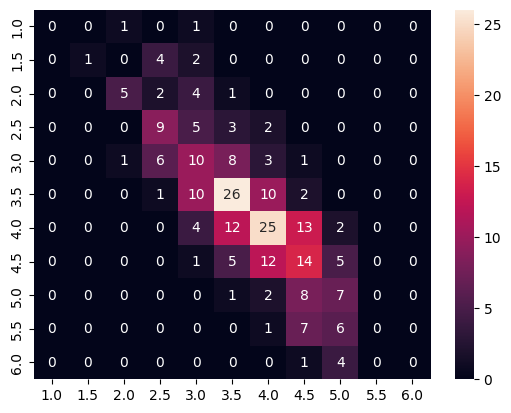

rmse: 0.6148367210474559

Fold_2 Training ================================

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[20]	train's l2: 0.817563	valid's l2: 0.671473
[40]	train's l2: 0.664501	valid's l2: 0.527648
[60]	train's l2: 0.569499	valid's l2: 0.440981
[80]	train's l2: 0.508535	valid's l2: 0.386127
[100]	train's l2: 0.466537	valid's l2: 0.351908
[120]	train's l2: 0.438764	valid's l2: 0.331917
[140]	train's l2: 0.418803	valid's l2: 0.319794
[160]	train's l2: 0.404042	valid's l2: 0.31143
[180]	train's l2: 0.392569	valid's l2: 0.30533
[200]	train's l2: 0.384048	valid's l2: 0.300568
[220]	train's l2: 0.377228	valid's l2: 0.297736
[240]	train's l2: 0.371679	valid's l2: 0.294757
[260]	train's l2: 0.366428	valid's l2: 0.292611
[280]	train's l2: 0.361573	valid's l2: 0.291076
[300]	train's l2: 0.357643	valid's l2: 0.289706
[320]	train's l2: 0.353722	valid's l2: 0.288401
[340]	train's l2: 0.350324	valid's l2: 0.287556
[360]	train's l2: 0.346807	valid's l2: 0.287142
[380]	

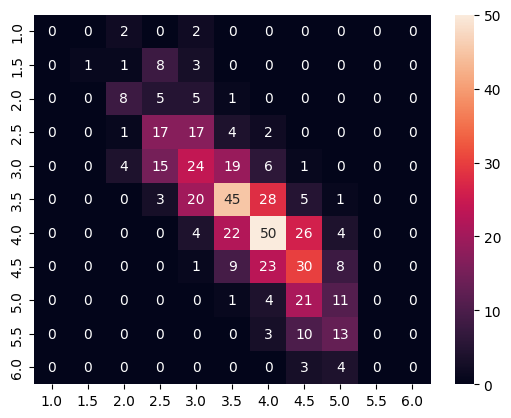

rmse: 0.5873240118958997

Fold_3 Training ================================

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[20]	train's l2: 0.796725	valid's l2: 0.850738
[40]	train's l2: 0.643642	valid's l2: 0.712955
[60]	train's l2: 0.5486	valid's l2: 0.632653
[80]	train's l2: 0.487908	valid's l2: 0.585425
[100]	train's l2: 0.446033	valid's l2: 0.553339
[120]	train's l2: 0.418325	valid's l2: 0.53481
[140]	train's l2: 0.398902	valid's l2: 0.524218
[160]	train's l2: 0.384755	valid's l2: 0.517575
[180]	train's l2: 0.374177	valid's l2: 0.512691
[200]	train's l2: 0.365799	valid's l2: 0.508843
[220]	train's l2: 0.359062	valid's l2: 0.505137
[240]	train's l2: 0.353636	valid's l2: 0.503341
[260]	train's l2: 0.348821	valid's l2: 0.500949
[280]	train's l2: 0.343881	valid's l2: 0.499199
[300]	train's l2: 0.339833	valid's l2: 0.49872
[320]	train's l2: 0.335831	valid's l2: 0.497633
[340]	train's l2: 0.332407	valid's l2: 0.496522
[360]	train's l2: 0.328748	valid's l2: 0.495184
[380]	tr

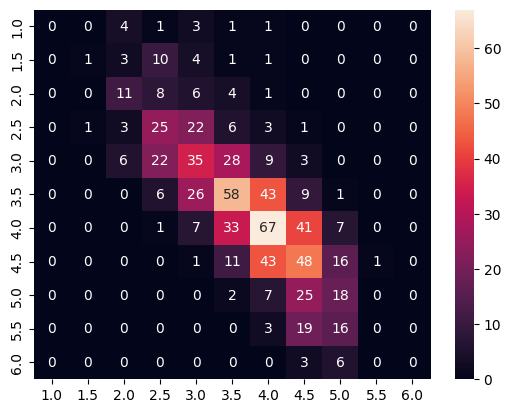

rmse: 0.6371791777688677

Fold_4 Training ================================

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[20]	train's l2: 0.791809	valid's l2: 0.915865
[40]	train's l2: 0.642093	valid's l2: 0.755883
[60]	train's l2: 0.549387	valid's l2: 0.655558
[80]	train's l2: 0.490736	valid's l2: 0.592922
[100]	train's l2: 0.451025	valid's l2: 0.549981
[120]	train's l2: 0.424155	valid's l2: 0.521485
[140]	train's l2: 0.405109	valid's l2: 0.502498
[160]	train's l2: 0.391484	valid's l2: 0.489142
[180]	train's l2: 0.381093	valid's l2: 0.478864
[200]	train's l2: 0.372908	valid's l2: 0.468992
[220]	train's l2: 0.366292	valid's l2: 0.461567
[240]	train's l2: 0.36093	valid's l2: 0.457233
[260]	train's l2: 0.356158	valid's l2: 0.453457
[280]	train's l2: 0.351539	valid's l2: 0.449867
[300]	train's l2: 0.347404	valid's l2: 0.447785
[320]	train's l2: 0.343673	valid's l2: 0.445398
[340]	train's l2: 0.340055	valid's l2: 0.444277
[360]	train's l2: 0.336767	valid's l2: 0.443143
[380]

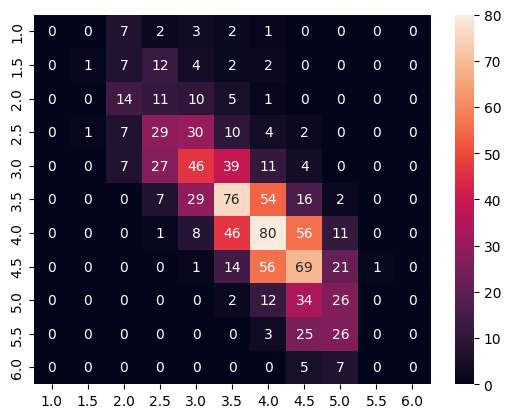

rmse: 0.6438634651691112

Fold_5 Training ================================

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[20]	train's l2: 0.808812	valid's l2: 0.732451
[40]	train's l2: 0.65484	valid's l2: 0.602317
[60]	train's l2: 0.560105	valid's l2: 0.525992
[80]	train's l2: 0.499657	valid's l2: 0.480195
[100]	train's l2: 0.459	valid's l2: 0.450085
[120]	train's l2: 0.431686	valid's l2: 0.431205
[140]	train's l2: 0.412649	valid's l2: 0.418721
[160]	train's l2: 0.398043	valid's l2: 0.409117
[180]	train's l2: 0.386818	valid's l2: 0.401807
[200]	train's l2: 0.377985	valid's l2: 0.396726
[220]	train's l2: 0.37115	valid's l2: 0.393652
[240]	train's l2: 0.365009	valid's l2: 0.39144
[260]	train's l2: 0.359716	valid's l2: 0.389822
[280]	train's l2: 0.354772	valid's l2: 0.388607
[300]	train's l2: 0.350227	valid's l2: 0.387389
[320]	train's l2: 0.346017	valid's l2: 0.386143
[340]	train's l2: 0.342481	valid's l2: 0.385225
[360]	train's l2: 0.338866	valid's l2: 0.384267
[380]	trai

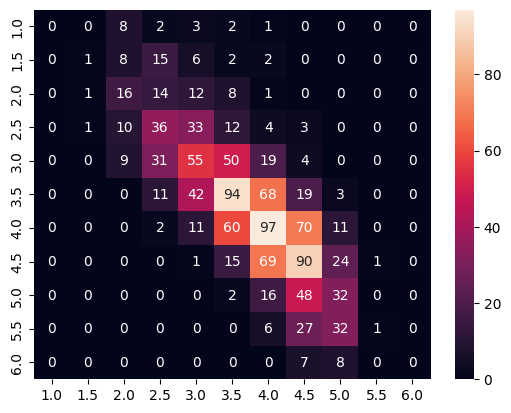

rmse: 0.6399901394871461

Fold_6 Training ================================

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[20]	train's l2: 0.795217	valid's l2: 0.86974
[40]	train's l2: 0.644453	valid's l2: 0.721026
[60]	train's l2: 0.551114	valid's l2: 0.62792
[80]	train's l2: 0.492091	valid's l2: 0.567432
[100]	train's l2: 0.452356	valid's l2: 0.528409
[120]	train's l2: 0.425519	valid's l2: 0.500887
[140]	train's l2: 0.406787	valid's l2: 0.481904
[160]	train's l2: 0.392684	valid's l2: 0.468043
[180]	train's l2: 0.38188	valid's l2: 0.456964
[200]	train's l2: 0.373482	valid's l2: 0.449158
[220]	train's l2: 0.366468	valid's l2: 0.44313
[240]	train's l2: 0.360868	valid's l2: 0.438835
[260]	train's l2: 0.355893	valid's l2: 0.435945
[280]	train's l2: 0.351036	valid's l2: 0.432083
[300]	train's l2: 0.346598	valid's l2: 0.430135
[320]	train's l2: 0.342496	valid's l2: 0.428843
[340]	train's l2: 0.339052	valid's l2: 0.427712
[360]	train's l2: 0.335911	valid's l2: 0.426518
[380]	tr

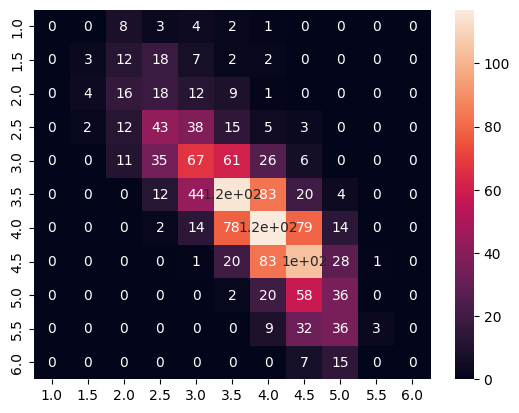

rmse: 0.6387149945278093

Fold_7 Training ================================

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[20]	train's l2: 0.788984	valid's l2: 0.930403
[40]	train's l2: 0.639988	valid's l2: 0.768345
[60]	train's l2: 0.548213	valid's l2: 0.668885
[80]	train's l2: 0.489166	valid's l2: 0.60589
[100]	train's l2: 0.448593	valid's l2: 0.565011
[120]	train's l2: 0.421656	valid's l2: 0.538333
[140]	train's l2: 0.402601	valid's l2: 0.519826
[160]	train's l2: 0.387893	valid's l2: 0.506087
[180]	train's l2: 0.376661	valid's l2: 0.495285
[200]	train's l2: 0.368104	valid's l2: 0.487214
[220]	train's l2: 0.361233	valid's l2: 0.4816
[240]	train's l2: 0.355546	valid's l2: 0.476486
[260]	train's l2: 0.350557	valid's l2: 0.473051
[280]	train's l2: 0.346417	valid's l2: 0.470125
[300]	train's l2: 0.342228	valid's l2: 0.468625
[320]	train's l2: 0.338126	valid's l2: 0.467221
[340]	train's l2: 0.334802	valid's l2: 0.466669
[360]	train's l2: 0.331444	valid's l2: 0.465992
[380]	t

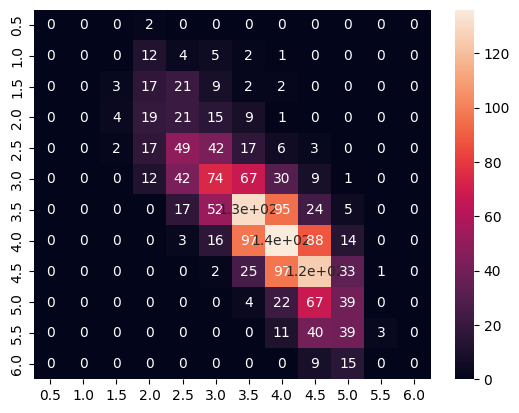

rmse: 0.6468018252572184

Fold_8 Training ================================

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[20]	train's l2: 0.803267	valid's l2: 0.765288
[40]	train's l2: 0.649327	valid's l2: 0.638441
[60]	train's l2: 0.554224	valid's l2: 0.564138
[80]	train's l2: 0.494028	valid's l2: 0.519643
[100]	train's l2: 0.453937	valid's l2: 0.490693
[120]	train's l2: 0.426421	valid's l2: 0.472148
[140]	train's l2: 0.407423	valid's l2: 0.459706
[160]	train's l2: 0.393317	valid's l2: 0.450416
[180]	train's l2: 0.381882	valid's l2: 0.444691
[200]	train's l2: 0.373141	valid's l2: 0.441027
[220]	train's l2: 0.366113	valid's l2: 0.439262
[240]	train's l2: 0.360262	valid's l2: 0.437902
[260]	train's l2: 0.355251	valid's l2: 0.437559
[280]	train's l2: 0.350165	valid's l2: 0.436547
[300]	train's l2: 0.34606	valid's l2: 0.435973
[320]	train's l2: 0.341943	valid's l2: 0.435077
[340]	train's l2: 0.338029	valid's l2: 0.434905
[360]	train's l2: 0.333828	valid's l2: 0.434039
[380]

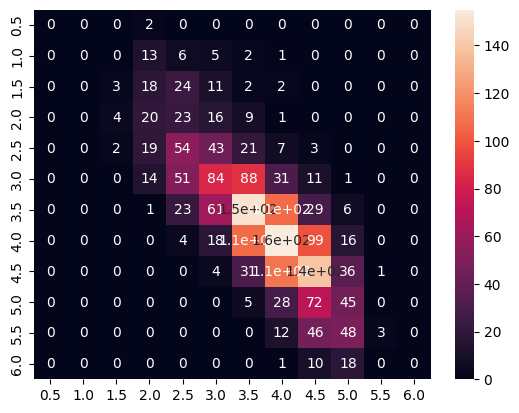

rmse: 0.6504735444803202

Fold_9 Training ================================

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[20]	train's l2: 0.796632	valid's l2: 0.872248
[40]	train's l2: 0.645353	valid's l2: 0.716097
[60]	train's l2: 0.551362	valid's l2: 0.624528
[80]	train's l2: 0.491291	valid's l2: 0.565101
[100]	train's l2: 0.450224	valid's l2: 0.530739
[120]	train's l2: 0.422352	valid's l2: 0.508368
[140]	train's l2: 0.40326	valid's l2: 0.492909
[160]	train's l2: 0.389716	valid's l2: 0.482646
[180]	train's l2: 0.378781	valid's l2: 0.474473
[200]	train's l2: 0.370277	valid's l2: 0.469043
[220]	train's l2: 0.363511	valid's l2: 0.465049
[240]	train's l2: 0.357588	valid's l2: 0.462302
[260]	train's l2: 0.352853	valid's l2: 0.459359
[280]	train's l2: 0.348312	valid's l2: 0.457751
[300]	train's l2: 0.344305	valid's l2: 0.456342
[320]	train's l2: 0.340498	valid's l2: 0.454869
[340]	train's l2: 0.336848	valid's l2: 0.453493
[360]	train's l2: 0.333446	valid's l2: 0.452023
[380]

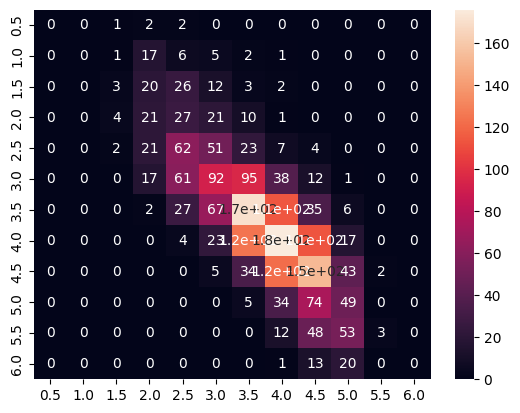

rmse: 0.6538314030368397

Fold_10 Training ================================

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[20]	train's l2: 0.811	valid's l2: 0.700571
[40]	train's l2: 0.658069	valid's l2: 0.561212
[60]	train's l2: 0.56311	valid's l2: 0.480333
[80]	train's l2: 0.503212	valid's l2: 0.431894
[100]	train's l2: 0.462663	valid's l2: 0.402215
[120]	train's l2: 0.435006	valid's l2: 0.384981
[140]	train's l2: 0.415406	valid's l2: 0.375218
[160]	train's l2: 0.400512	valid's l2: 0.36928
[180]	train's l2: 0.38877	valid's l2: 0.365316
[200]	train's l2: 0.379591	valid's l2: 0.360859
[220]	train's l2: 0.372584	valid's l2: 0.358612
[240]	train's l2: 0.367157	valid's l2: 0.356903
[260]	train's l2: 0.36213	valid's l2: 0.355863
[280]	train's l2: 0.357608	valid's l2: 0.355356
[300]	train's l2: 0.353311	valid's l2: 0.355076
[320]	train's l2: 0.348877	valid's l2: 0.35555
[340]	train's l2: 0.345212	valid's l2: 0.355713


,id,score,pred,pred_range
1,0022f953,3.5,3.722442,3.5
21,019737b6,3.5,4.683925,4.5
34,031c0c58,4.0,3.901502,4.0
64,0666fb4e,4.5,5.011390,5.0
95,09a67581,4.5,4.634764,4.5
98,09eb3ce5,3.0,2.836027,3.0
103,0a4e3aec,3.5,3.298289,3.5
122,0ca05fe3,1.5,2.925748,3.0
130,0d71be2a,4.5,4.339296,4.5
146,0f2b0127,3.5,3.001729,3.0


,id,score
0,0000aaaa,1.887779
1,2222bbbb,2.006153
2,4444cccc,1.986811


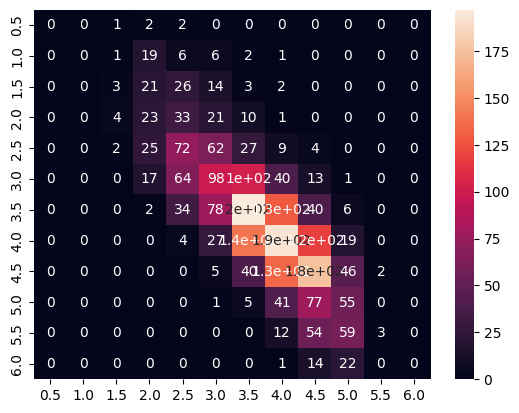

rmse: 0.650312006802754
***********xgb***************

Fold_1 Training ================================

[0]	validation_0-rmse:3.23484	validation_1-rmse:3.27322
[20]	validation_0-rmse:1.51438	validation_1-rmse:1.54752
[40]	validation_0-rmse:0.84452	validation_1-rmse:0.88432
[60]	validation_0-rmse:0.62130	validation_1-rmse:0.68047
[80]	validation_0-rmse:0.54953	validation_1-rmse:0.62370
[100]	validation_0-rmse:0.52001	validation_1-rmse:0.61087
[120]	validation_0-rmse:0.50174	validation_1-rmse:0.60955
[140]	validation_0-rmse:0.48591	validation_1-rmse:0.60642
[160]	validation_0-rmse:0.47300	validation_1-rmse:0.60709
[180]	validation_0-rmse:0.46049	validation_1-rmse:0.60678
[200]	validation_0-rmse:0.44854	validation_1-rmse:0.60820


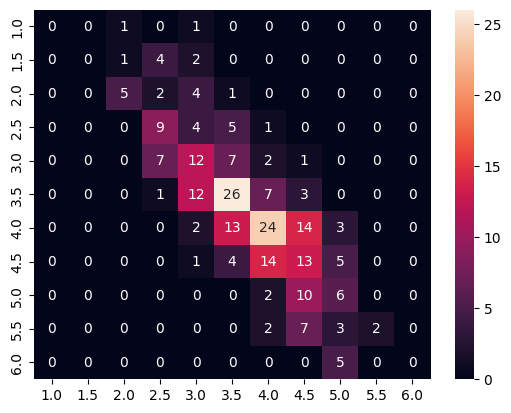

rmse: 0.60157722803504

Fold_2 Training ================================

[0]	validation_0-rmse:3.24384	validation_1-rmse:3.19942
[20]	validation_0-rmse:1.51887	validation_1-rmse:1.48219
[40]	validation_0-rmse:0.84803	validation_1-rmse:0.81447
[60]	validation_0-rmse:0.62352	validation_1-rmse:0.60499
[80]	validation_0-rmse:0.55438	validation_1-rmse:0.55289
[100]	validation_0-rmse:0.52468	validation_1-rmse:0.54190
[120]	validation_0-rmse:0.50660	validation_1-rmse:0.53851
[140]	validation_0-rmse:0.49090	validation_1-rmse:0.53730
[160]	validation_0-rmse:0.47741	validation_1-rmse:0.53863
[180]	validation_0-rmse:0.46488	validation_1-rmse:0.53657
[200]	validation_0-rmse:0.45384	validation_1-rmse:0.53558
[220]	validation_0-rmse:0.44060	validation_1-rmse:0.53471
[240]	validation_0-rmse:0.42919	validation_1-rmse:0.53400
[260]	validation_0-rmse:0.41790	validation_1-rmse:0.53362
[280]	validation_0-rmse:0.40642	validation_1-rmse:0.53441
[300]	validation_0-rmse:0.39566	validation_1-rmse:0.53383


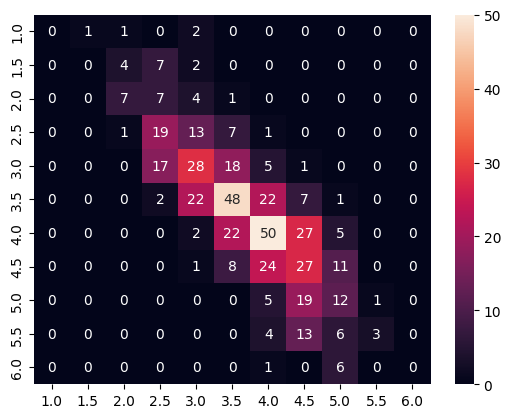

rmse: 0.5729597091269405

Fold_3 Training ================================

[0]	validation_0-rmse:3.24190	validation_1-rmse:3.20664
[20]	validation_0-rmse:1.51445	validation_1-rmse:1.49508
[40]	validation_0-rmse:0.83781	validation_1-rmse:0.88274
[60]	validation_0-rmse:0.61051	validation_1-rmse:0.72794
[80]	validation_0-rmse:0.54104	validation_1-rmse:0.70228
[100]	validation_0-rmse:0.51292	validation_1-rmse:0.69896
[120]	validation_0-rmse:0.49363	validation_1-rmse:0.69894
[140]	validation_0-rmse:0.47785	validation_1-rmse:0.69783
[160]	validation_0-rmse:0.46287	validation_1-rmse:0.69783


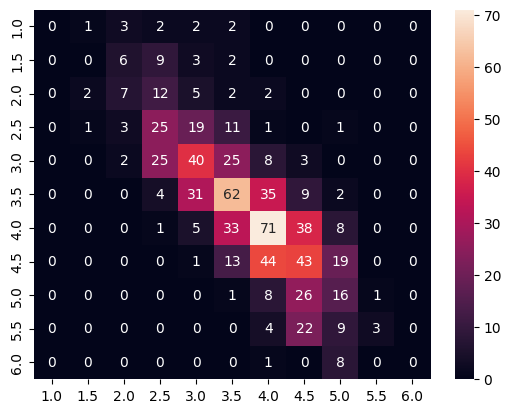

rmse: 0.6251684409139866

Fold_4 Training ================================

[0]	validation_0-rmse:3.23582	validation_1-rmse:3.26669
[20]	validation_0-rmse:1.51539	validation_1-rmse:1.52664
[40]	validation_0-rmse:0.84249	validation_1-rmse:0.88002
[60]	validation_0-rmse:0.61817	validation_1-rmse:0.69894
[80]	validation_0-rmse:0.54831	validation_1-rmse:0.66265
[100]	validation_0-rmse:0.51906	validation_1-rmse:0.65975
[120]	validation_0-rmse:0.50001	validation_1-rmse:0.65934
[140]	validation_0-rmse:0.48511	validation_1-rmse:0.65638
[160]	validation_0-rmse:0.47187	validation_1-rmse:0.65717
[180]	validation_0-rmse:0.45731	validation_1-rmse:0.65744
[200]	validation_0-rmse:0.44493	validation_1-rmse:0.65708
[216]	validation_0-rmse:0.43556	validation_1-rmse:0.65808


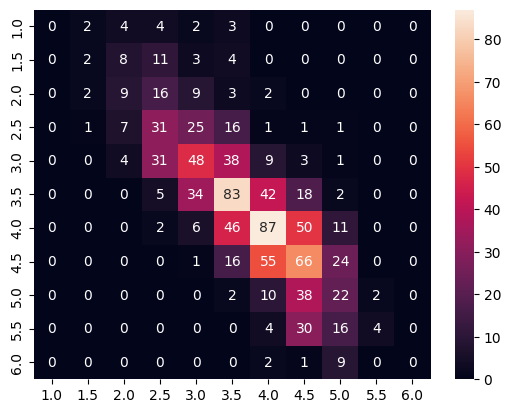

rmse: 0.6355653995842088

Fold_5 Training ================================

[0]	validation_0-rmse:3.23404	validation_1-rmse:3.27506
[20]	validation_0-rmse:1.51141	validation_1-rmse:1.55223
[40]	validation_0-rmse:0.84269	validation_1-rmse:0.90020
[60]	validation_0-rmse:0.62013	validation_1-rmse:0.69510
[80]	validation_0-rmse:0.54783	validation_1-rmse:0.64111
[100]	validation_0-rmse:0.51906	validation_1-rmse:0.62697
[120]	validation_0-rmse:0.50271	validation_1-rmse:0.61993
[140]	validation_0-rmse:0.48616	validation_1-rmse:0.61561
[160]	validation_0-rmse:0.47245	validation_1-rmse:0.61250
[180]	validation_0-rmse:0.45802	validation_1-rmse:0.60952
[200]	validation_0-rmse:0.44459	validation_1-rmse:0.61112
[220]	validation_0-rmse:0.43376	validation_1-rmse:0.60973
[240]	validation_0-rmse:0.42154	validation_1-rmse:0.61003
[260]	validation_0-rmse:0.41009	validation_1-rmse:0.61015
[280]	validation_0-rmse:0.39849	validation_1-rmse:0.61175
[296]	validation_0-rmse:0.38982	validation_1-rmse:0.61163


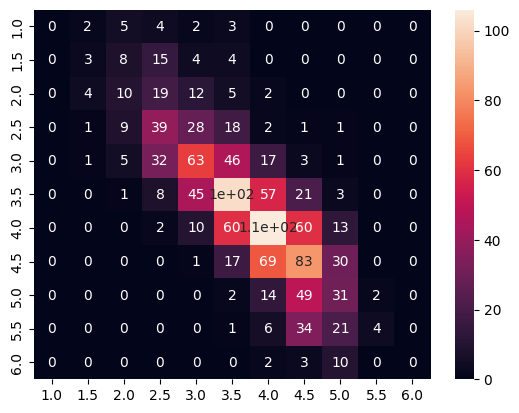

rmse: 0.6331587223102438

Fold_6 Training ================================

[0]	validation_0-rmse:3.23363	validation_1-rmse:3.28163
[20]	validation_0-rmse:1.51417	validation_1-rmse:1.57255
[40]	validation_0-rmse:0.84116	validation_1-rmse:0.91843
[60]	validation_0-rmse:0.61607	validation_1-rmse:0.71308
[80]	validation_0-rmse:0.54593	validation_1-rmse:0.65380
[100]	validation_0-rmse:0.51522	validation_1-rmse:0.63681
[120]	validation_0-rmse:0.49662	validation_1-rmse:0.63162
[140]	validation_0-rmse:0.48116	validation_1-rmse:0.62789
[160]	validation_0-rmse:0.46716	validation_1-rmse:0.62467
[180]	validation_0-rmse:0.45366	validation_1-rmse:0.62134
[200]	validation_0-rmse:0.44066	validation_1-rmse:0.61775
[220]	validation_0-rmse:0.42818	validation_1-rmse:0.61836
[240]	validation_0-rmse:0.41582	validation_1-rmse:0.61856
[260]	validation_0-rmse:0.40503	validation_1-rmse:0.61834
[280]	validation_0-rmse:0.39420	validation_1-rmse:0.61652
[300]	validation_0-rmse:0.38507	validation_1-rmse:0.61649
[3

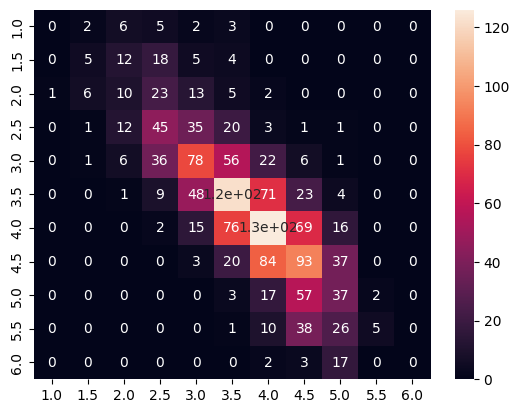

rmse: 0.634345171305601

Fold_7 Training ================================

[0]	validation_0-rmse:3.24190	validation_1-rmse:3.21214
[20]	validation_0-rmse:1.51795	validation_1-rmse:1.54645
[40]	validation_0-rmse:0.84182	validation_1-rmse:0.91973
[60]	validation_0-rmse:0.61497	validation_1-rmse:0.73001
[80]	validation_0-rmse:0.54196	validation_1-rmse:0.68342
[100]	validation_0-rmse:0.51276	validation_1-rmse:0.66883
[120]	validation_0-rmse:0.49353	validation_1-rmse:0.66427
[140]	validation_0-rmse:0.47854	validation_1-rmse:0.66262
[160]	validation_0-rmse:0.46452	validation_1-rmse:0.66168
[180]	validation_0-rmse:0.45198	validation_1-rmse:0.66089
[200]	validation_0-rmse:0.43910	validation_1-rmse:0.66066
[201]	validation_0-rmse:0.43871	validation_1-rmse:0.66059


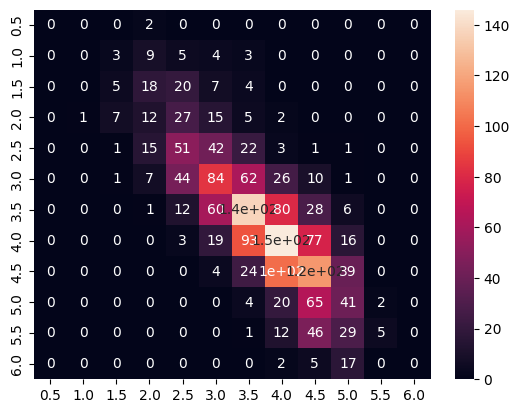

rmse: 0.6415299631674413

Fold_8 Training ================================

[0]	validation_0-rmse:3.23277	validation_1-rmse:3.30058
[20]	validation_0-rmse:1.51268	validation_1-rmse:1.58897
[40]	validation_0-rmse:0.84063	validation_1-rmse:0.93523
[60]	validation_0-rmse:0.61482	validation_1-rmse:0.72694
[80]	validation_0-rmse:0.54486	validation_1-rmse:0.67066
[100]	validation_0-rmse:0.51473	validation_1-rmse:0.65604
[120]	validation_0-rmse:0.49400	validation_1-rmse:0.65087
[140]	validation_0-rmse:0.47867	validation_1-rmse:0.65132
[160]	validation_0-rmse:0.46402	validation_1-rmse:0.65312
[178]	validation_0-rmse:0.45179	validation_1-rmse:0.65289


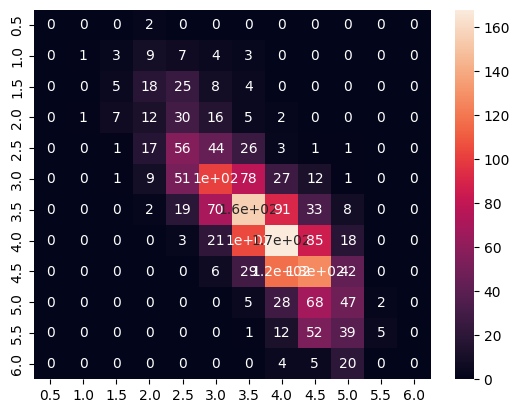

rmse: 0.6445169698549108

Fold_9 Training ================================

[0]	validation_0-rmse:3.24927	validation_1-rmse:3.13746
[20]	validation_0-rmse:1.51871	validation_1-rmse:1.47371
[40]	validation_0-rmse:0.84346	validation_1-rmse:0.86932
[60]	validation_0-rmse:0.61810	validation_1-rmse:0.70107
[80]	validation_0-rmse:0.54796	validation_1-rmse:0.66428
[100]	validation_0-rmse:0.51865	validation_1-rmse:0.65433
[120]	validation_0-rmse:0.50114	validation_1-rmse:0.65122
[140]	validation_0-rmse:0.48506	validation_1-rmse:0.65045
[160]	validation_0-rmse:0.47022	validation_1-rmse:0.64905
[180]	validation_0-rmse:0.45672	validation_1-rmse:0.64981
[197]	validation_0-rmse:0.44719	validation_1-rmse:0.64902


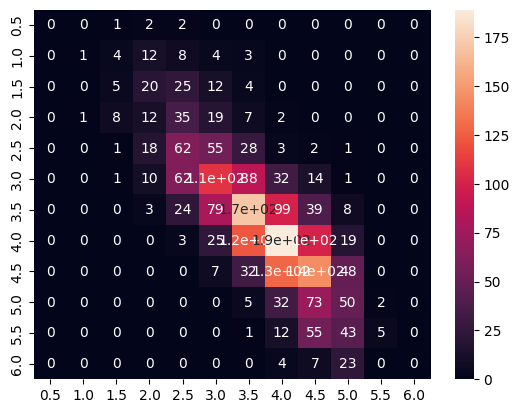

rmse: 0.6487397855477325

Fold_10 Training ================================

[0]	validation_0-rmse:3.23905	validation_1-rmse:3.23442
[20]	validation_0-rmse:1.51651	validation_1-rmse:1.52600
[40]	validation_0-rmse:0.84519	validation_1-rmse:0.87236
[60]	validation_0-rmse:0.62208	validation_1-rmse:0.66967
[80]	validation_0-rmse:0.55046	validation_1-rmse:0.61540
[100]	validation_0-rmse:0.51979	validation_1-rmse:0.60559
[120]	validation_0-rmse:0.49864	validation_1-rmse:0.60436
[140]	validation_0-rmse:0.48424	validation_1-rmse:0.60125
[160]	validation_0-rmse:0.46924	validation_1-rmse:0.60144
[180]	validation_0-rmse:0.45690	validation_1-rmse:0.60320
[193]	validation_0-rmse:0.44851	validation_1-rmse:0.60292


,id,score,pred,pred_10,pred_range
1,0022f953,3.5,3.743905,3.743905,3.5
21,019737b6,3.5,4.708785,4.708785,4.5
34,031c0c58,4.0,3.951663,3.951663,4.0
64,0666fb4e,4.5,5.068535,5.068535,5.0
95,09a67581,4.5,4.833965,4.833965,5.0
98,09eb3ce5,3.0,2.664947,2.664947,2.5
103,0a4e3aec,3.5,3.330105,3.330105,3.5
122,0ca05fe3,1.5,2.765160,2.765160,3.0
130,0d71be2a,4.5,4.240096,4.240096,4.0
146,0f2b0127,3.5,2.964138,2.964138,3.0


,id,score
0,0000aaaa,1.159334
1,2222bbbb,1.445507
2,4444cccc,1.399241


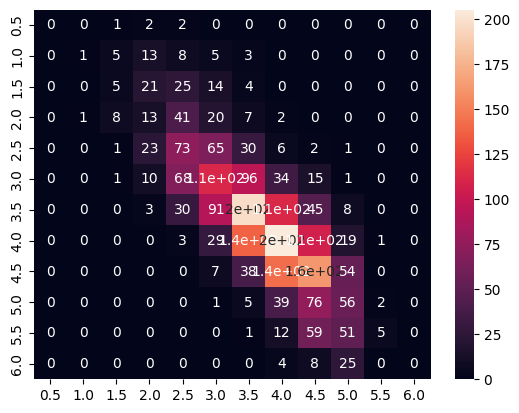

rmse: 0.6461760632010337


In [49]:
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for key, value in models.items():
        print(f"***********{key}***************")
        best_model = value["model"]
        oof = []
        prediction = test_feats[[exp_key_column]]
        prediction[obj_column] = 0
        df_importance_list = []
        for fold_id, (trn_idx, val_idx) in enumerate(kfold.split(train_feats[feature_names])):
            X_train = train_feats.iloc[trn_idx][feature_names]
            Y_train = train_feats.iloc[trn_idx][obj_column]

            X_val = train_feats.iloc[val_idx][feature_names]
            Y_val = train_feats.iloc[val_idx][obj_column]

            print('\nFold_{} Training ================================\n'.format(fold_id+1))
            best_model = value["model"]

            ## we have to change because each models have different params
            if key == "xgb":
                model = best_model.fit(X_train,
                                      Y_train,
                                      # eval_names=['train', 'valid'],
                                      eval_set=[(X_train, Y_train), (X_val, Y_val)],
                                      verbose=20,
                                      # eval_metric= [metric],
                                      early_stopping_rounds=50)
                pred_val = model.predict(X_val)
                pred_test = model.predict(test_feats[feature_names])
                prediction[obj_column] += pred_test / kfold.n_splits
                df_oof = train_feats.iloc[val_idx][[exp_key_column, obj_column]].copy()
                df_oof['pred'] = pred_val
                df_oof[f"pred_{fold_id+1}"] = pred_val
                oof.append(df_oof)
                df_oof["pred_range"] = classify_predict_vectorize(pred_val)
                if fold_id + 1 == n_splits:
                    display(df_oof.head(10))
                    display(prediction.head(10))
                    
            elif key == "lgb":
                model = best_model.fit(X_train,Y_train,
                              eval_names=['train', 'valid'],
                              eval_set=[(X_train, Y_train), (X_val, Y_val)],
                              verbose=20,
                              eval_metric= metric,
                              early_stopping_rounds=50)
                pred_val = model.predict(X_val, num_iteration=model.best_iteration_)
                pred_test = model.predict(test_feats[feature_names], num_iteration=model.best_iteration_)
                prediction[obj_column] += pred_test / kfold.n_splits
                df_oof = train_feats.iloc[val_idx][[exp_key_column, obj_column]].copy()
                df_oof['pred'] = pred_val
                oof.append(df_oof)
                df_oof["pred_range"] = classify_predict_vectorize(pred_val)
                if fold_id + 1 == n_splits:
                    display(df_oof.head(10))
                    display(prediction.head(10))

            elif key == "rf":
                model = best_model.fit(X_train,Y_train)
                pred_val = model.predict(X_val)
                pred_test = model.predict(test_feats[feature_names])
                prediction[obj_column] += pred_test / kfold.n_splits
                df_oof = train_feats.iloc[val_idx][[exp_key_column, obj_column]].copy()
                df_oof['pred'] = pred_val
                oof.append(df_oof)
                if fold_id + 1 == n_splits:
                    display(df_oof.head(10))
                    display(prediction.head(10))
            elif key == "tpot":
                model = best_model.fit(X_train,
                          Y_train,
                          eval_names=['train', 'valid'],
                          eval_set=[(X_train, Y_train), (X_val, Y_val)],
                          verbose=20,
                          eval_metric= metric,
                          early_stopping_rounds=50)
                pred_val = model.predict(X_val, num_iteration=model.best_iteration_)
                pred_test = model.predict(test_feats[feature_names], num_iteration=model.best_iteration_)
                prediction[obj_column] += pred_test / kfold.n_splits
                df_oof = train_feats.iloc[val_idx][[exp_key_column, obj_column]].copy()
                df_oof['pred'] = pred_val
                oof.append(df_oof)
                df_oof["pred_range"] = classify_predict_vectorize(pred_val)
                if fold_id + 1 == n_splits:
                    display(df_oof.head(10))
                    display(prediction.head(10))
                
            models[key]["prediction"] = prediction
            if key in ["lgb","xgb"]:
                df_importance = pd.DataFrame({
                    'column': feature_names,
                    'importance': model.feature_importances_,
                })
                df_importance_list.append(df_importance)
            else:
                df_importance = pd.DataFrame([])
            del model, pred_val, pred_test
            gc.collect()
            df_oof = pd.concat(oof)
            labels = sorted(list(set(df_oof[obj_column].astype(str))))
            rmse = mean_squared_error(df_oof[obj_column], df_oof["pred_range"], squared=False)
            df = pd.DataFrame(confusion_matrix(df_oof[obj_column].astype(str), df_oof["pred_range"].astype(str)), index=labels, columns=labels)
            plt.figure()
            sns.heatmap(df, annot=True) # annot = Falseにすると図中の各セルの数値表示がなくなる。
            plt.show()
            print('rmse:', rmse)
            models[key]["score"] = rmse

In [50]:
# oof = []
# prediction = test_feats[[exp_key_column]]
# prediction[obj_column] = 0
# df_importance_list = []

# kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
# for fold_id, (trn_idx, val_idx) in enumerate(kfold.split(train_feats[feature_names])):
#     X_train = train_feats.iloc[trn_idx][feature_names]
#     Y_train = train_feats.iloc[trn_idx][obj_column]

#     X_val = train_feats.iloc[val_idx][feature_names]
#     Y_val = train_feats.iloc[val_idx][obj_column]

#     print('\nFold_{} Training ================================\n'.format(fold_id+1))
#     for key, value in models.items():
#         print(f"***********{key}***************")
#         best_model = value["model"]
        
#         ## we have to change because each models have different params
#         if key == "xgb":
#             model = best_model.fit(X_train,
#                                   Y_train,
#                                   # eval_names=['train', 'valid'],
#                                   eval_set=[(X_train, Y_train), (X_val, Y_val)],
#                                   verbose=20,
#                                   # eval_metric= [metric],
#                                   early_stopping_rounds=50)
#             pred_val = model.predict(X_val)
#             pred_test = model.predict(test_feats[feature_names])
#             prediction[obj_column] += pred_test / kfold.n_splits
#             df_oof = train_feats.iloc[val_idx][[exp_key_column, obj_column]].copy()
#             df_oof['pred'] = pred_val
#             oof.append(df_oof)
#             df_oof["pred_range"] = classify_predict_vectorize(pred_val)
#             display(df_oof.head(10))
#         elif key == "lgb":
#             model = best_model.fit(X_train,
#                       Y_train,
#                       eval_names=['train', 'valid'],
#                       eval_set=[(X_train, Y_train), (X_val, Y_val)],
#                       verbose=20,
#                       eval_metric= metric,
#                       early_stopping_rounds=50)
#             pred_val = model.predict(X_val, num_iteration=model.best_iteration_)
#             pred_test = model.predict(test_feats[feature_names], num_iteration=model.best_iteration_)
#             prediction[obj_column] += pred_test / kfold.n_splits
#             df_oof = train_feats.iloc[val_idx][[exp_key_column, obj_column]].copy()
#             df_oof['pred'] = pred_val
#             oof.append(df_oof)
#             df_oof["pred_range"] = classify_predict_vectorize(pred_val)
#             display(df_oof.head(10))
        
#         elif key == "rf":
#             model = best_model.fit(X_train,Y_train)
#             pred_val = model.predict(X_val)
#             pred_test = model.predict(test_feats[feature_names])
#             prediction[obj_column] += pred_test / kfold.n_splits
#             df_oof = train_feats.iloc[val_idx][[exp_key_column, obj_column]].copy()
#             df_oof['pred'] = pred_val
#             oof.append(df_oof)
#             display(df_oof.head(10))
#         elif key == "tpot":
#             model = best_model.fit(X_train,
#                       Y_train,
#                       eval_names=['train', 'valid'],
#                       eval_set=[(X_train, Y_train), (X_val, Y_val)],
#                       verbose=20,
#                       eval_metric= metric,
#                       early_stopping_rounds=50)
#             pred_val = model.predict(X_val, num_iteration=model.best_iteration_)
#             pred_test = model.predict(test_feats[feature_names], num_iteration=model.best_iteration_)
#             prediction[obj_column] += pred_test / kfold.n_splits
#             df_oof = train_feats.iloc[val_idx][[exp_key_column, obj_column]].copy()
#             df_oof['pred'] = pred_val
#             oof.append(df_oof)
#             df_oof["pred_range"] = classify_predict_vectorize(pred_val)
#             display(df_oof.head(10))
            
#         models[key]["prediction"] = prediction
#         if key in ["lgb","xgb"]:
#             df_importance = pd.DataFrame({
#                 'column': feature_names,
#                 'importance': model.feature_importances_,
#             })
#             df_importance_list.append(df_importance)
#         else:
#             df_importance = pd.DataFrame([])
#         del model, pred_val, pred_test
#         gc.collect()
#         df_oof = pd.concat(oof)
#         rmse = mean_squared_error(df_oof[obj_column], np.clip(df_oof['pred'], a_min=0.5, a_max=6.0), squared=False)
#         print('rmse:', rmse)
#         models[key]["score"] = rmse

In [51]:
for key, value in models.items():
    print(key)
#     print(value.values())
#     print(value["model"])
    print(value["score"])

lgb
0.650312006802754
xgb
0.6461760632010337


# 3. submission

In [52]:
prediction

,id,score
0,0000aaaa,1.159334
1,2222bbbb,1.445507
2,4444cccc,1.399241


In [53]:
# prediction['score'] = np.clip(prediction['score'], a_min=0.5, a_max=6.0)
display(models["lgb"]["prediction"])
#prediction['score'] = classify_predict_vectorize(models["lgb"]["prediction"]["score"]
prediction['score'] = models["lgb"]["prediction"]["score"]
display(prediction)
prediction.to_csv('submission.csv', index=False)

,id,score
0,0000aaaa,1.887779
1,2222bbbb,2.006153
2,4444cccc,1.986811


,id,score
0,0000aaaa,1.887779
1,2222bbbb,2.006153
2,4444cccc,1.986811
